In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy.special import i0
from sklearn.metrics import r2_score
from scipy.stats import zscore
from scipy.stats import binned_statistic
from scipy.signal import correlation_lags
from scipy.signal import correlate

In [2]:
from fly2p_function_TQ.imaging_2p_preprocessing import low_pass_filter_TQ,get_dff_array
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude_V3,  PVAangleToRoi, PVA_radian_to_angle,calculateBumpWidth_v1, von_Mises_fitting_dff_TQ,calcualteBumpAmplitude ,calcualteBumpAmplitude_V4
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import offset_calculation, moving_wrapped_plot_by_offset
from fly2p_function_TQ.imaging_2p_bar_juimping_analysis import sliding_circular_mean

In [3]:
#Read the imaging/behavior data after preprocessing
pd_imaging_behavior_preprocessed = pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dark_cl_Ca_imaging/PEG/PEG_EB(syt)_(16_ROI_F)/dark/TQfly083-009-imaging-normalized.csv')
pd_imaging_behavior_preprocessed

Time_Stamp   F_Roi_1    F_Roi_2    F_Roi_3    F_Roi_4    F_Roi_5   
0        0.00000  6.316116   8.846527   9.443054   7.374106  15.805075  \
1        0.11709  7.665366   4.855988   7.407899   6.993201  17.616271   
2        0.23418  6.710285   6.229412   7.441576   8.543862  20.133328   
3        0.35127  9.057007   8.464378   8.465411   7.545120  16.954235   
4        0.46836  7.938145   5.457719   9.532506   7.646932  16.954988   
...          ...       ...        ...        ...        ...        ...   
2558   299.51622  9.877699  11.600834  17.236167  16.742898  13.544949   
2559   299.63331  5.848872   5.621425  19.131604  18.287461  12.307524   
2560   299.75040  8.601359   8.327972  18.943375  15.257612  14.714006   
2561   299.86749  7.455347   8.214361  19.951092  13.413789  12.885977   
2562   299.98458  4.234523   7.181003  11.234716  13.421561  10.814683   

        F_Roi_6    F_Roi_7   F_Roi_8    Raw_F_1  ...  PVA_Radian_offset   
0     33.991934  33.383606  9.478265   6.528800  ...          -0.500719  \
1     43.540772  36.649255  6.657614  10.305179  ...          -0.574525   
2     41.770812  30.454121  5.092292   5.429574  ...          -0.530821   
3     37.373618  33.376971  7.731458   9.587851  ...          -0.498557   
4     34.938700  36.970624  8.698307   6.405373  ...          -0.418286   
...         ...        ...       ...        ...  ...                ...   
2558   8.722380   8.455041  6.087568  10.133349  ...           2.787699   
2559   9.566384   8.165025  3.111333   5.477009  ...           2.687178   
2560   8.124380   8.259882  4.955932   8.479671  ...           2.961236   
2561   9.936712   8.437865  2.510430   7.128509  ...           2.641748   
2562   9.283449   7.851838  6.402079   4.464666  ...          -3.131708   

       PVA_Angle  Angular_Velocity  Bar_Position/Heading   
0     -85.984850          1.029203             -3.050390  \
1     -90.213662          0.522386             -2.929880   
2     -87.709566          0.274397             -2.928058   
3     -85.860968          0.786617             -2.865622   
4     -81.261781          0.947599             -2.743848   
...          ...               ...                   ...   
2558  102.427580          1.083206              0.549253   
2559   96.668178          1.611797              0.738824   
2560  112.370529          0.728310              0.926704   
2561   94.065216         -0.634147              0.909380   
2562  123.270585         -1.120340              0.778199   

      Unwrapped_Bar_Position/Heading  Unwrapped_Radian  Integrated_x   
0                          -3.050390         -0.500719     -4.582045  \
1                          -2.929880         -0.574525     -4.516030   
2                          -2.928058         -0.530821     -4.505780   
3                          -2.865622         -0.498557     -4.454161   
4                          -2.743848         -0.418286     -4.414023   
...                              ...               ...           ...   
2558                       -5.733932         21.637254      4.098334   
2559                       -5.544361         21.536734      4.155428   
2560                       -5.356482         21.810792      4.185063   
2561                       -5.373806         21.491304      4.206927   
2562                       -5.504986         22.001033      4.207189   

      Integrated_y  PVA_strength  Bump_amplitude  
0         1.152132      2.102874        1.125752  
1         1.164179      2.379976        1.438538  
2         1.156201      2.298180        1.444745  
3         1.132296      2.198540        1.277067  
4         1.097398      2.212030        1.211739  
...            ...           ...             ...  
2558     20.019800      0.837383        0.496793  
2559     20.070557      0.699201        0.365721  
2560     20.076186      0.696950        0.397328  
2561     20.095195      0.530283        0.262010  
2562     20.063731      0.419583        0.269716  

[2563 rows x 44 c

In [4]:
trial_type = 0

In [5]:
dual_imaging = 0
bar_jumping = 0

In [6]:
volume_cycle = len(pd_imaging_behavior_preprocessed)
volume_time = pd_imaging_behavior_preprocessed['Time_Stamp'][1]
volume_rate = 1/volume_time
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [7]:
PVA_Unwrapped_Radian = pd_imaging_behavior_preprocessed['Unwrapped_Radian'].values
PVA_Angle = pd_imaging_behavior_preprocessed['PVA_Angle'].values
PVA_Radian = pd_imaging_behavior_preprocessed['PVA_Radian'].values
Angular_velocity = pd_imaging_behavior_preprocessed['Angular_Velocity'].values
integrated_x = pd_imaging_behavior_preprocessed['Integrated_x'].values
PVA_strength = pd_imaging_behavior_preprocessed['PVA_strength'].values
Bump_amplitude = pd_imaging_behavior_preprocessed['Bump_amplitude'].values
Unwrapped_heading = pd_imaging_behavior_preprocessed['Unwrapped_Bar_Position/Heading'].values
if bar_jumping == 1:
    Wrapped_heading =-pd_imaging_behavior_preprocessed['Bar_Position/Heading_jumping_bar'].values
else:    
    Wrapped_heading =pd_imaging_behavior_preprocessed['Bar_Position/Heading'].values

if dual_imaging == 1:
    PVA_Angle_red = pd_imaging_behavior_preprocessed['PVA_Angle_red'].values
    PVA_Radian_red = pd_imaging_behavior_preprocessed['PVA_Radian_red'].values
    PVA_strength_red = pd_imaging_behavior_preprocessed['PVA_strength_red'].values
    Bump_amplitude_red = pd_imaging_behavior_preprocessed['Bump_amplitude_red'].values

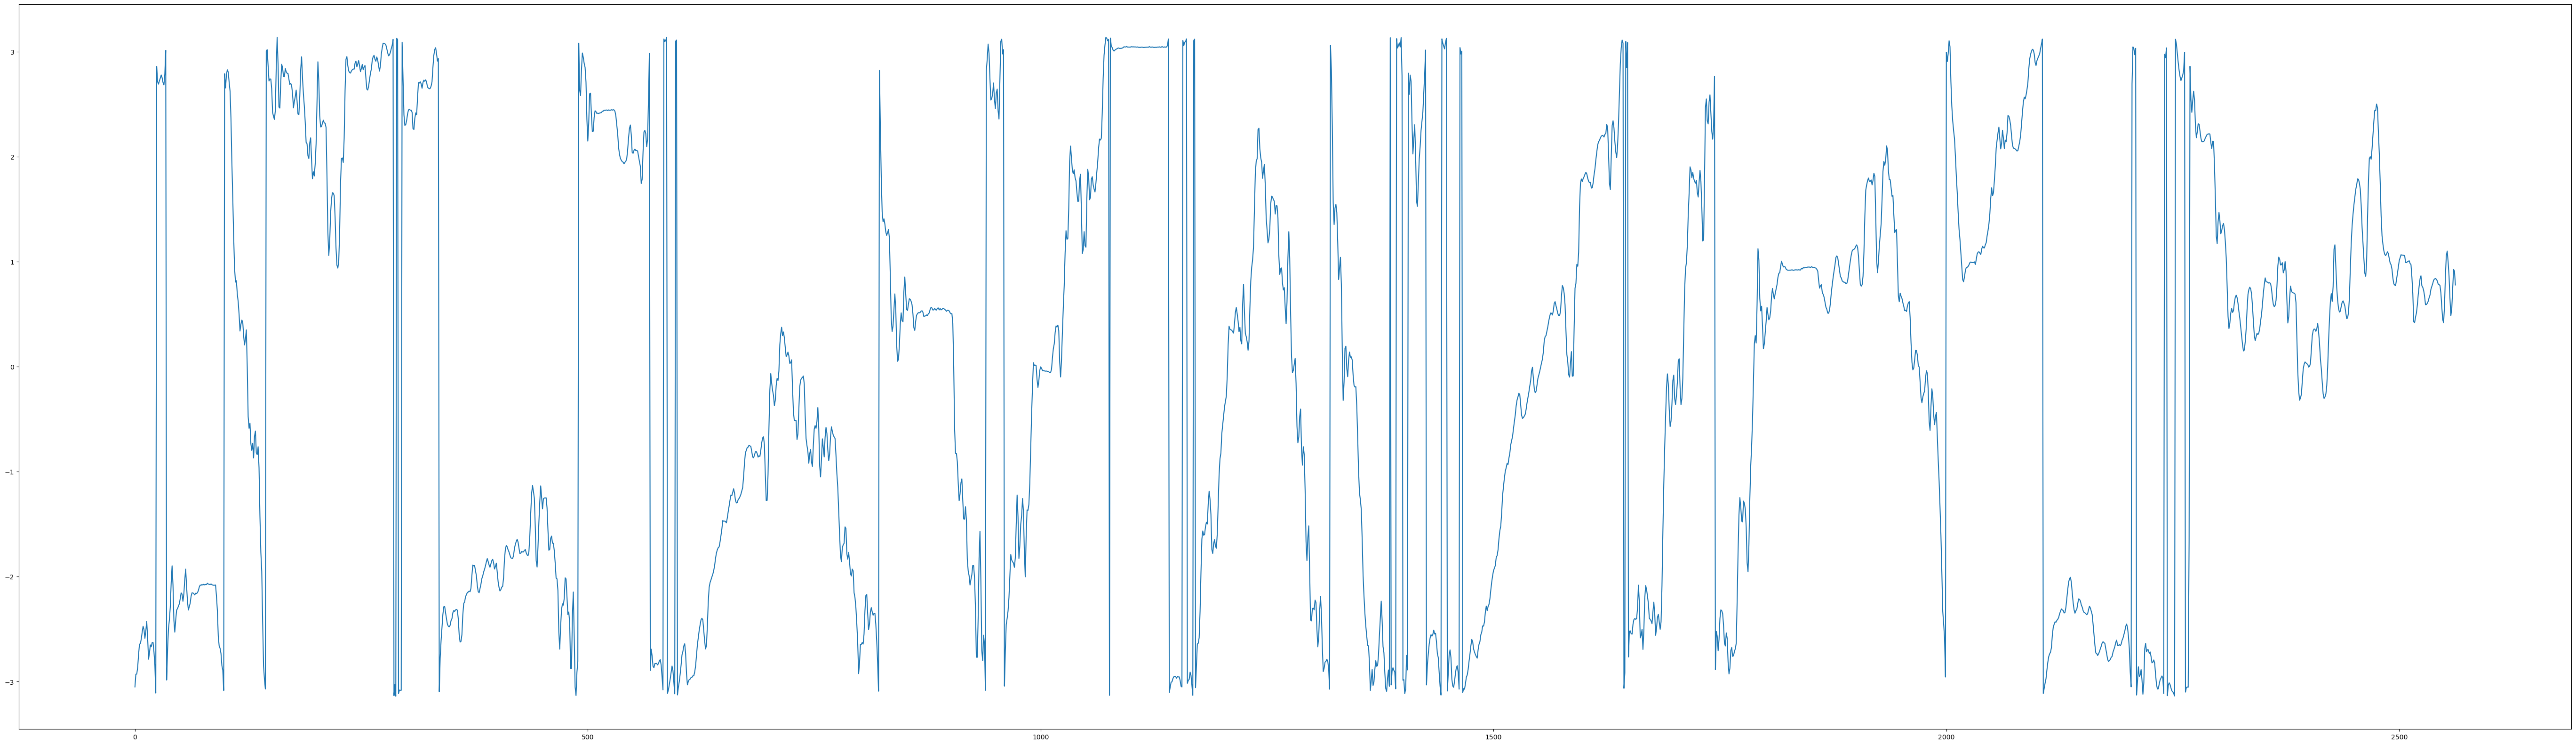

In [8]:
plt.figure(figsize= (70,20))
plt.plot(Wrapped_heading)

In [9]:
def find_regular_subarray(arr, length, interval, tolerance=1):
    n = len(arr)
    
    for i in range(n):
        subarray = [arr[i]]
        
        for j in range(1, length):
            next_value = subarray[-1] + interval
            
            # Search for the next value within the tolerance
            next_index = np.where(np.isclose(arr, next_value, atol=tolerance))[0]
            
            if len(next_index) > 0:
                subarray.append(arr[next_index[0]])
            else:
                break
        
        if len(subarray) == length:
            return subarray
    
    return []

In [10]:
def find_pi_changes(angular_positions, num_points=10):
    from collections import Counter
    # Ensure the input is a numpy array for easy manipulation
    angular_positions = np.array(angular_positions)
    
    # Compute differences between adjacent points
    differences = np.diff(angular_positions)
    
    # Normalize the differences to be within the range [-π, π]
    normalized_differences = (differences + np.pi) % (2 * np.pi) - np.pi
    
    # Find indices where the normalized difference is close to ±π
    pi_changes_indices = np.where((np.abs(normalized_differences) >= 1))[0]
    
    # Calculate the differences between consecutive elements
    diffs = np.diff(pi_changes_indices)
    test  =   pi_changes_indices
    # Filter out the differences that are equal to 1
    diffs = [diff for diff in diffs if diff > 1]
    
    # Find the most common difference
    diff_counts = Counter(diffs)
    most_common_diff, _ = diff_counts.most_common(1)[0]
    
    selected_indices = find_regular_subarray(pi_changes_indices, 10,most_common_diff)
    
    
 
    
    return selected_indices, test

In [11]:
if bar_jumping == 1:
    jumping_frame, diff = find_pi_changes(Wrapped_heading)
    print(jumping_frame)

In [12]:
#if bar_jumping == 1:
    #pd_jumping_frame = pd.DataFrame()
    #pd_jumping_frame ['jumping_frame'] = jumping_frame 
    #pd_jumping_frame.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dual_imaging/R55G08_syt7f_R27F02_lexopjRGECO1a(bar_jump)/TQfly360-002-jumping-frame.csv',encoding = 'utf-8', index=False)

In [13]:
raw_F_16_roi = np.array([pd_imaging_behavior_preprocessed[f'Raw_F_{i}'] for i in range(1, 17)]).T
F_8_roi = np.array([pd_imaging_behavior_preprocessed[f'F_Roi_{i}'] for i in range(1, 9)]).T
dff_normalized_8_roi = np.array([pd_imaging_behavior_preprocessed[f'dFF_Roi_{i}'] for i in range(1, 9)]).T

if dual_imaging == 1:
    raw_F_16_roi_red = np.array([pd_imaging_behavior_preprocessed[f'Raw_F_{i}_red'] for i in range(1, 17)]).T
    F_8_roi_red = np.array([pd_imaging_behavior_preprocessed[f'F_Roi_{i}_red'] for i in range(1, 9)]).T
    dff_normalized_8_roi_red = np.array([pd_imaging_behavior_preprocessed[f'dFF_Roi_{i}_red'] for i in range(1, 9)]).T

In [14]:
bump_amplitude_F_v3 = calcualteBumpAmplitude_V3(F_8_roi,PVA_Radian)[0]
bump_amplitude_dff_normalized_v3 = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian)[0]

if dual_imaging == 1:
    bump_amplitude_F_v3_red = calcualteBumpAmplitude_V3(F_8_roi_red,PVA_Radian_red)[0]
    bump_amplitude_dff_normalized_v3_red = calcualteBumpAmplitude_V3(dff_normalized_8_roi_red,PVA_Radian_red)[0]

In [15]:
integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x,time_array_imaging, 10, already_radian = True)
Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
Forward_speed_radian = np.abs(Forward_velocity)
Forward_speed_degrees =Forward_speed_radian * 180/np.pi
angular_speed_degrees = np.abs(Angular_velocity*180/np.pi)

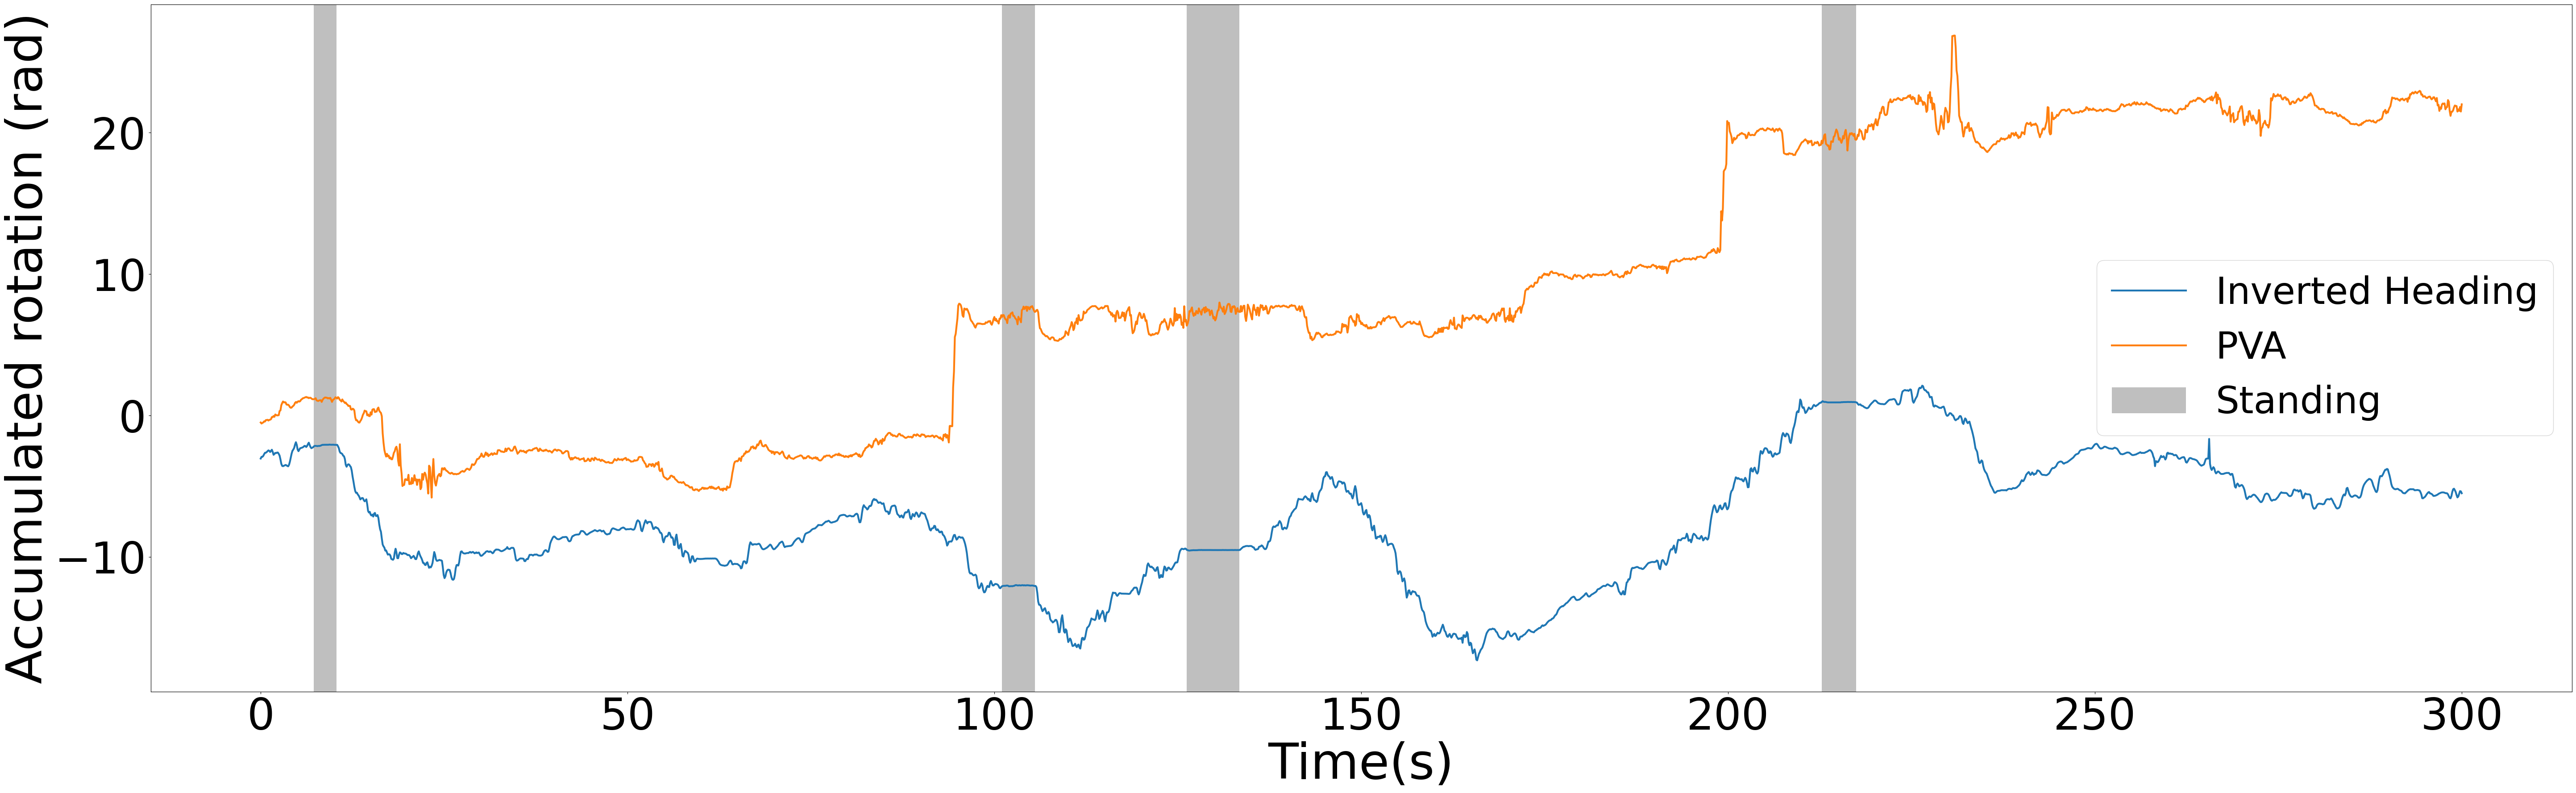

In [16]:
#find stop period and plot as shaded under unwrapped PVA/behavior
persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,Unwrapped_heading ,linewidth =3)
plt.plot(time_array_imaging, PVA_Unwrapped_Radian,linewidth =3)
#plt.plot(time_array_imaging, Forward_speed_radian,linewidth =3)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Accumulated rotation (rad)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    plt.legend(['Inverted Heading','PVA','Standing'],fontsize=60)
else:
    plt.legend(['Bar Position','PVA','Standing'],fontsize=60)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
#plt.grid()
plt.show()

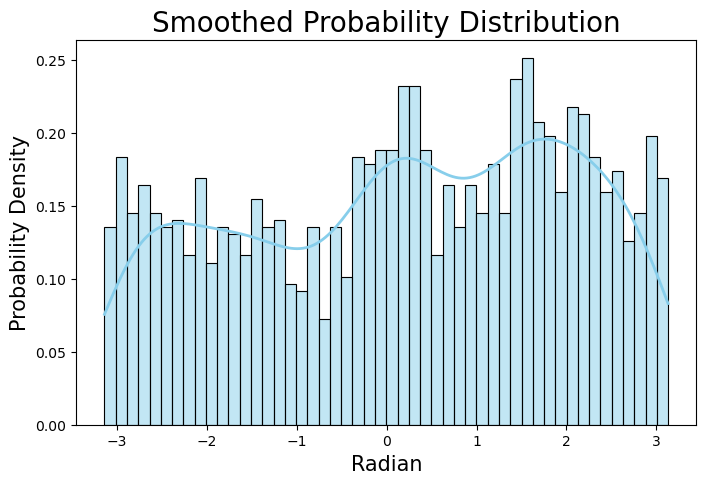

In [17]:
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_Radian, IfRadian = True)
# Bump offset excluding low velocity point
if dual_imaging == 1:
    radian_offset_normalized_red = offset_calculation(Wrapped_heading, PVA_Radian_red, IfRadian = True)
    radian_offset_no_stopping_period_normalized_red = []

radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity)):
    if np.abs(Angular_velocity[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])
        if dual_imaging == 1:
            radian_offset_no_stopping_period_normalized_red.append(radian_offset_normalized_red[i])


if dual_imaging == 1:
    data = np.array(radian_offset_no_stopping_period_normalized)
    data_red = np.array(radian_offset_no_stopping_period_normalized_red)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # Plot the first smoothed probability distribution
    sns.histplot(data, stat='density', bins=50, kde=True, color='skyblue', line_kws={'linewidth': 2}, ax=ax1)

    # Customize the first plot's labels and title
    ax1.set_title('delta7 offset distribution', fontsize=20)
    ax1.set_xlabel('Radian', fontsize=15)
    ax1.set_ylabel('Probability Density', fontsize=15)
    # ax1.set_ylim(0, 0.5)
    
    # Plot the second smoothed probability distribution
    sns.histplot(data_red , stat='density', bins=50, kde=True, color='salmon', line_kws={'linewidth': 2}, ax=ax2)

    # Customize the second plot's labels and title
    ax2.set_title('EPG Offset Distribution', fontsize=20)
    ax2.set_xlabel('Radian', fontsize=15)
    ax2.set_ylabel('Probability Density', fontsize=15)
    plt.show()

else:
    data = np.array(radian_offset_no_stopping_period_normalized)
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the smoothed probability distribution
    sns.histplot(data, stat='density', bins= 50, kde=True, color='skyblue', line_kws={'linewidth': 2},ax=ax)

    # Customize plot labels and title
    ax.set_title('Smoothed Probability Distribution', fontsize=20)
    ax.set_xlabel('Radian', fontsize=15)
    ax.set_ylabel('Probability Density', fontsize=15)
    #ax.set_ylim(0,0.5)
    plt.show()

In [18]:
from scipy.stats import circvar
from scipy.stats import circmean
circular_va = circvar(radian_offset_normalized,high=np.pi, low= -np.pi)
print(f'Circular VA: {circular_va}')
circular_mean = circmean(radian_offset_normalized,high=np.pi, low= -np.pi)
print(f'Circular Mean: {circular_mean}')

if dual_imaging == 1:
    circular_va_red = circvar(radian_offset_normalized_red,high=np.pi, low= -np.pi)
    print(f'Circular VA_red: {circular_va_red}')
    circular_mean_red = circmean(radian_offset_normalized_red,high=np.pi, low= -np.pi)
    print(f'Circular Mean_red: {circular_mean_red}')


Circular VA: 0.8573752821463566
Circular Mean: 1.6705498680745938


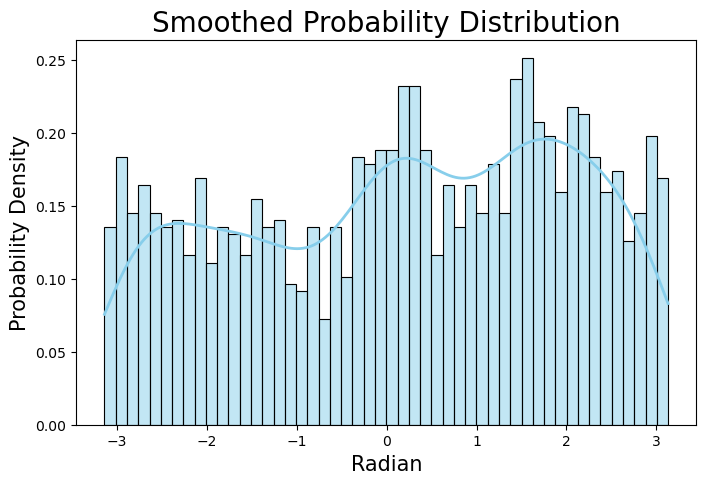

In [19]:
PVA_radian_array_normalized_offset = moving_wrapped_plot_by_offset(PVA_Radian,math.degrees(0), ifRadian =True)
if dual_imaging == 1:
    PVA_radian_array_normalized_offset_red = moving_wrapped_plot_by_offset(PVA_Radian_red,math.degrees(0), ifRadian =True)
radian_offset_normalized = offset_calculation(Wrapped_heading, PVA_radian_array_normalized_offset, IfRadian = True)\
# Bump offset excluding low velocity point
radian_offset_no_stopping_period_normalized = []
for i in range(len(Angular_velocity)):
    if np.abs(Angular_velocity[i]) >= 0.26:
        radian_offset_no_stopping_period_normalized.append(radian_offset_normalized[i])
# Assuming radian_offset_no_stopping_period_normalized is your data
data = np.array(radian_offset_no_stopping_period_normalized)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the smoothed probability distribution
sns.histplot(data, stat='density', bins= 50, kde=True, color='skyblue', line_kws={'linewidth': 2})

# Customize plot labels and title
ax.set_title('Smoothed Probability Distribution', fontsize=20)
ax.set_xlabel('Radian', fontsize=15)
ax.set_ylabel('Probability Density', fontsize=15)
#ax.set_ylim(0,0.5)

# Display the plot
plt.show()

In [20]:
radian_offset_normalized

array([-1.54967101, -1.35535489, -1.39723679, ..., -1.03453199,
       -0.73236799, -1.37327845])

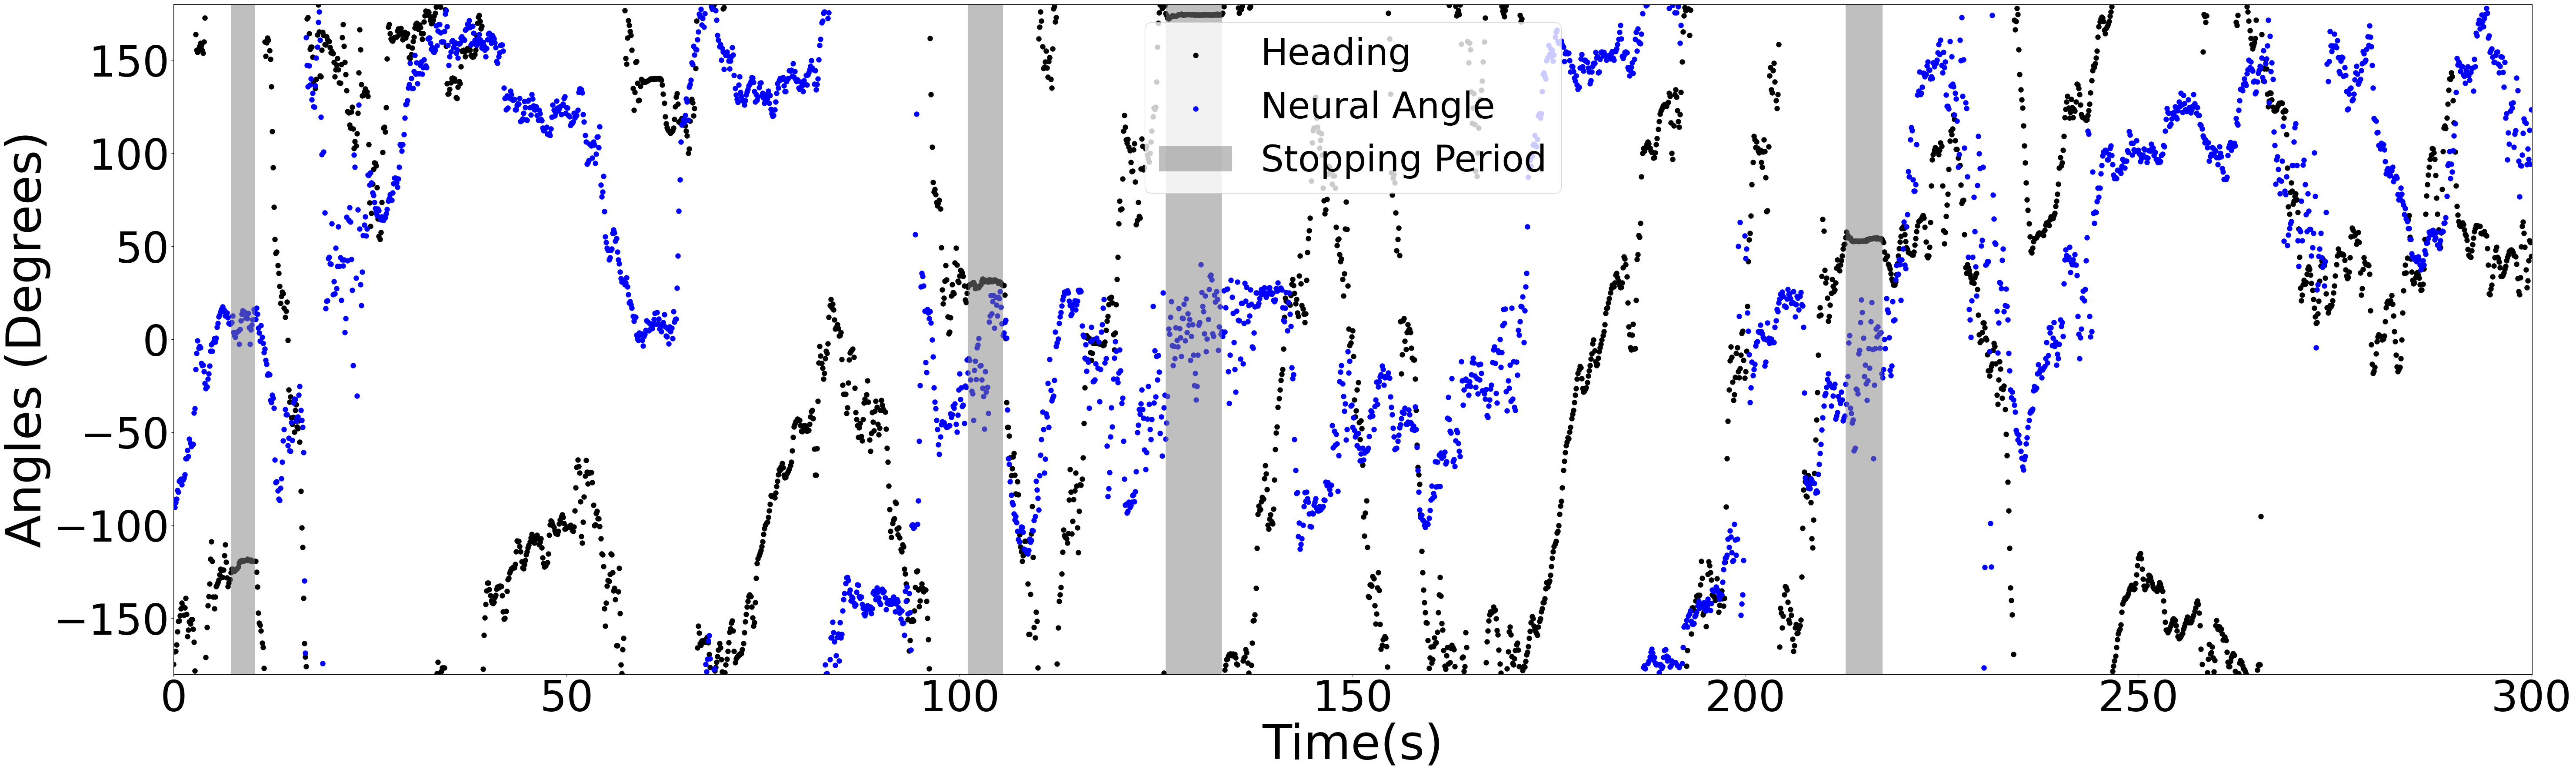

In [21]:
#Plot the stoping period as shaded under wrapped behavior
b = plt.figure(figsize= (70,20))
#PVA_radian_array_normalized_offset_filtered = low_pass_filter_TQ(PVA_radian_array_normalized_offset,0.5,volume_rate)
#PVA_radian_array_normalized_offset_filtered_angle = PVA_radian_to_angle(PVA_radian_array_normalized_offset_filtered)
PVA_angle_offset = PVA_radian_to_angle(PVA_radian_array_normalized_offset)
Wrapped_heading_angle = PVA_radian_to_angle(Wrapped_heading )


if dual_imaging == 1:
    #PVA_radian_array_normalized_offset_filtered_red = low_pass_filter_TQ(PVA_radian_array_normalized_offset_red,0.5,volume_rate)
    PVA_radian_array_normalized_offset_filtered_angle_red = PVA_radian_to_angle(PVA_radian_array_normalized_offset_red)

plt.scatter(time_array_imaging,Wrapped_heading_angle ,color ='black', linewidth =3)
plt.scatter(time_array_imaging,PVA_angle_offset, color ='blue',linewidth = 3)

if dual_imaging == 1:
    plt.scatter(time_array_imaging,PVA_radian_array_normalized_offset_filtered_angle_red, color ='red',linewidth = 3)

if bar_jumping == 1:
    for i in range(len(jumping_frame)):
            plt.axvline(x=jumping_frame[i]*volume_time, color='purple', linestyle='--',linewidth = 4)
plt.xlabel('Time(s)', fontsize=80)
plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Angles (Degrees)', fontsize=80)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
if trial_type == 0:
    if dual_imaging == 1:
        plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
        plt.legend(['Heading','Neural Angle (Δ7)','Neural Angle (EPG)'],fontsize=60)
    else:
        plt.legend(['Inverted Heading','PVA','Stopping Period'],fontsize=60)
        plt.legend(['Heading','Neural Angle','Stopping Period'],fontsize=60)
else:
    if dual_imaging == 1:
        plt.legend(['Bar Position','PVA 1','PVA 2','Stopping Period'],fontsize=60, loc = 4)
    else: 
        plt.legend(['Bar Position','PVA','Stopping Period'],fontsize=60, loc = 4)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
#plt.xlim(0,500*volume_time)
plt.ylim(-180, 180)
plt.show()
#b.savefig('Behavior_trace_with_EPG_RGECO_PB_delta7_syt7f_PB_274_002_0_500', format ='svg')

In [22]:
persistence_stop_index_and_length

array([[  88,   26],
       [ 901,   38],
       [1139,   61],
       [1857,   40]])

In [23]:
persistence_stop_index_and_length[0][0]

88

In [24]:
def smooth_circular_data(data, sigma):
    # Convert the angles to complex exponential form
    complex_data = np.exp(1j * data)
    
    # Apply Gaussian smoothing in the complex plane
    smoothed_complex_data = gaussian_filter1d(complex_data, sigma=sigma, axis=-1)
    
    # Normalize to keep the magnitude as 1
    smoothed_complex_data /= np.abs(smoothed_complex_data)
    
    # Convert the smoothed complex data back to angles
    smoothed_data = np.angle(smoothed_complex_data)
    
    return smoothed_data

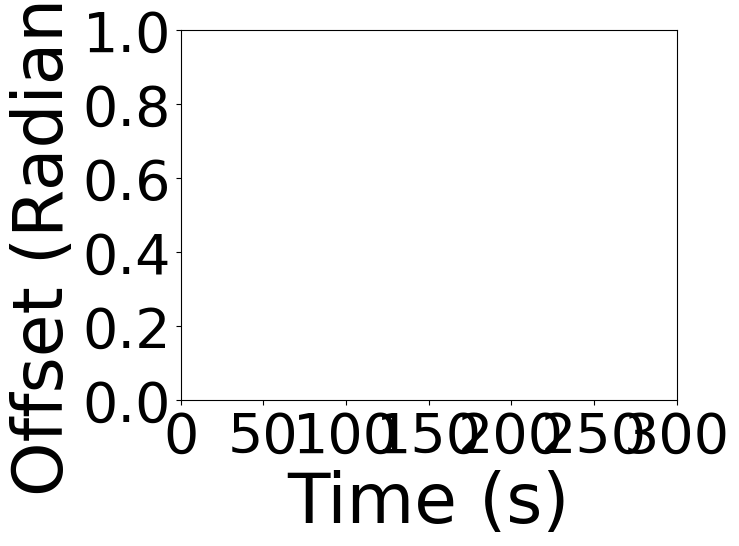

In [25]:
if bar_jumping == 1:
    plt.figure(figsize= (50,10))
    radian_offset_normalized_smoothed = smooth_circular_data(radian_offset_normalized, 5)
    #plt.scatter(time_array_imaging,radian_offset_normalized,marker='o')
    plt.scatter(time_array_imaging,radian_offset_normalized_smoothed,marker='o')
    for i in range(len(jumping_frame)):
        plt.axvline(x=jumping_frame[i]*volume_time, color='purple', linestyle='--',linewidth = 4)
        plt.axhline(y= (circular_mean+0.8 +np.pi) % (2 * np.pi) - np.pi, color = 'b',linestyle ='--')
        plt.axhline(y= circular_mean, color = 'r',linestyle ='--')
        plt.axhline(y= (circular_mean-0.8 +np.pi) % (2 * np.pi) - np.pi, color = 'b',linestyle ='--')
plt.ylabel('Offset (Radians)', fontsize=50)
plt.xlabel('Time (s)', fontsize=50)
plt.xlim(0,volume_cycle*volume_time)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.show()

In [26]:
(circular_mean-0.4 +np.pi) % (2 * np.pi) - np.pi

-2.6997470636459324

NameError: name 'jumping_frame' is not defined

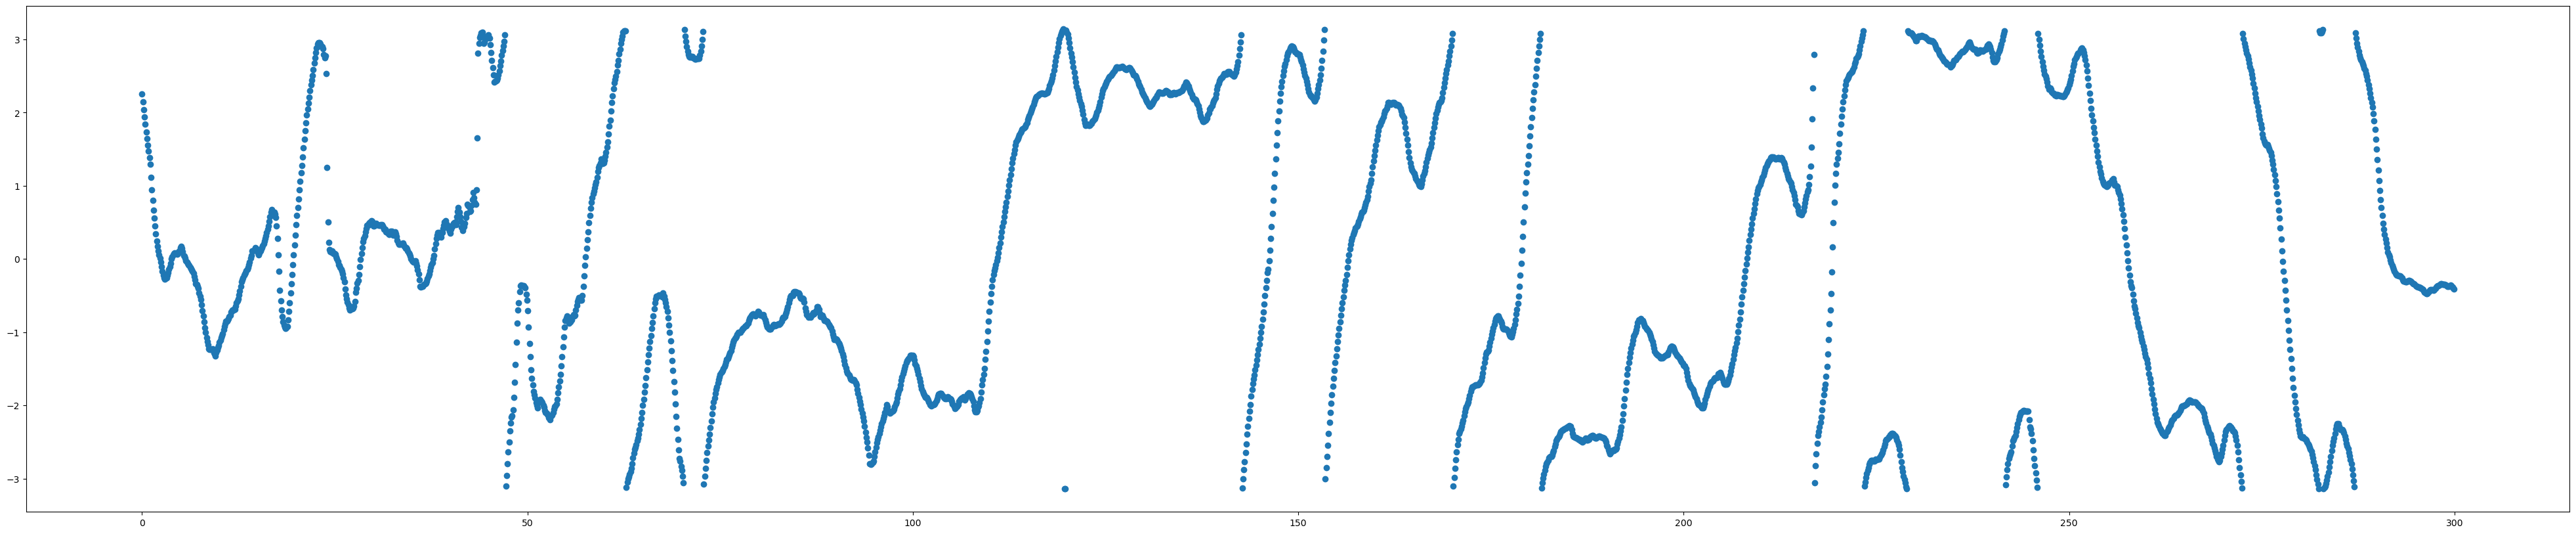

In [27]:
window_size = 20  # Define the sliding window size
circular_means = sliding_circular_mean(radian_offset_normalized, window_size)

# Plotting the result
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 10))
#plt.plot(radian_offset_normalized, label='Original Data', marker='o')
plt.scatter(time_array_imaging,circular_means, label='Sliding Circular Mean', marker='o')
for i in range(len(jumping_frame)):
        plt.axvline(x=jumping_frame[i]*volume_time, color='purple', linestyle='-',linewidth = 2)
plt.legend()
plt.xlabel('Frame')
plt.ylabel('Angle (radians)')
plt.title('Sliding Circular Mean of Radian Offset')
plt.show()

In [ ]:
radian_offset_normalized

In [28]:
plt.figure(figsize= (80,30))
plt.plot(time_array_imaging,circular_speed(radian_offset_normalized),linewidth = 2)
for i in range(len(jumping_frame)):
        plt.axvline(x=jumping_frame[i]*volume_time, color='purple', linestyle='-',linewidth = 2)
plt.show()

NameError: name 'circular_speed' is not defined

<Figure size 8000x3000 with 0 Axes>

In [29]:
def circular_speed(data, sigma=1):
    # Compute the circular differences
    circular_diff = np.diff(data, append=data[-1])
    circular_diff = (circular_diff + np.pi) % (2 * np.pi) - np.pi
    
    # Smooth the circular differences
    smoothed_diff = gaussian_filter1d(circular_diff, sigma=sigma)
    
    # Compute the speed as the magnitude of the differences
    speed = np.abs(smoothed_diff)
    
    return speed

In [30]:
if bar_jumping == 1:
    plt.figure(figsize= (30,10))
    for i in range(len(jumping_frame)):
        current_time = np.arange(len(radian_offset_normalized[jumping_frame[i]:jumping_frame[i]+int(29/volume_time)]))/volume_rate
        plt.plot(current_time,circular_speed(circular_means[jumping_frame[i]:jumping_frame[i]+int(29/volume_time)]))
    plt.show()

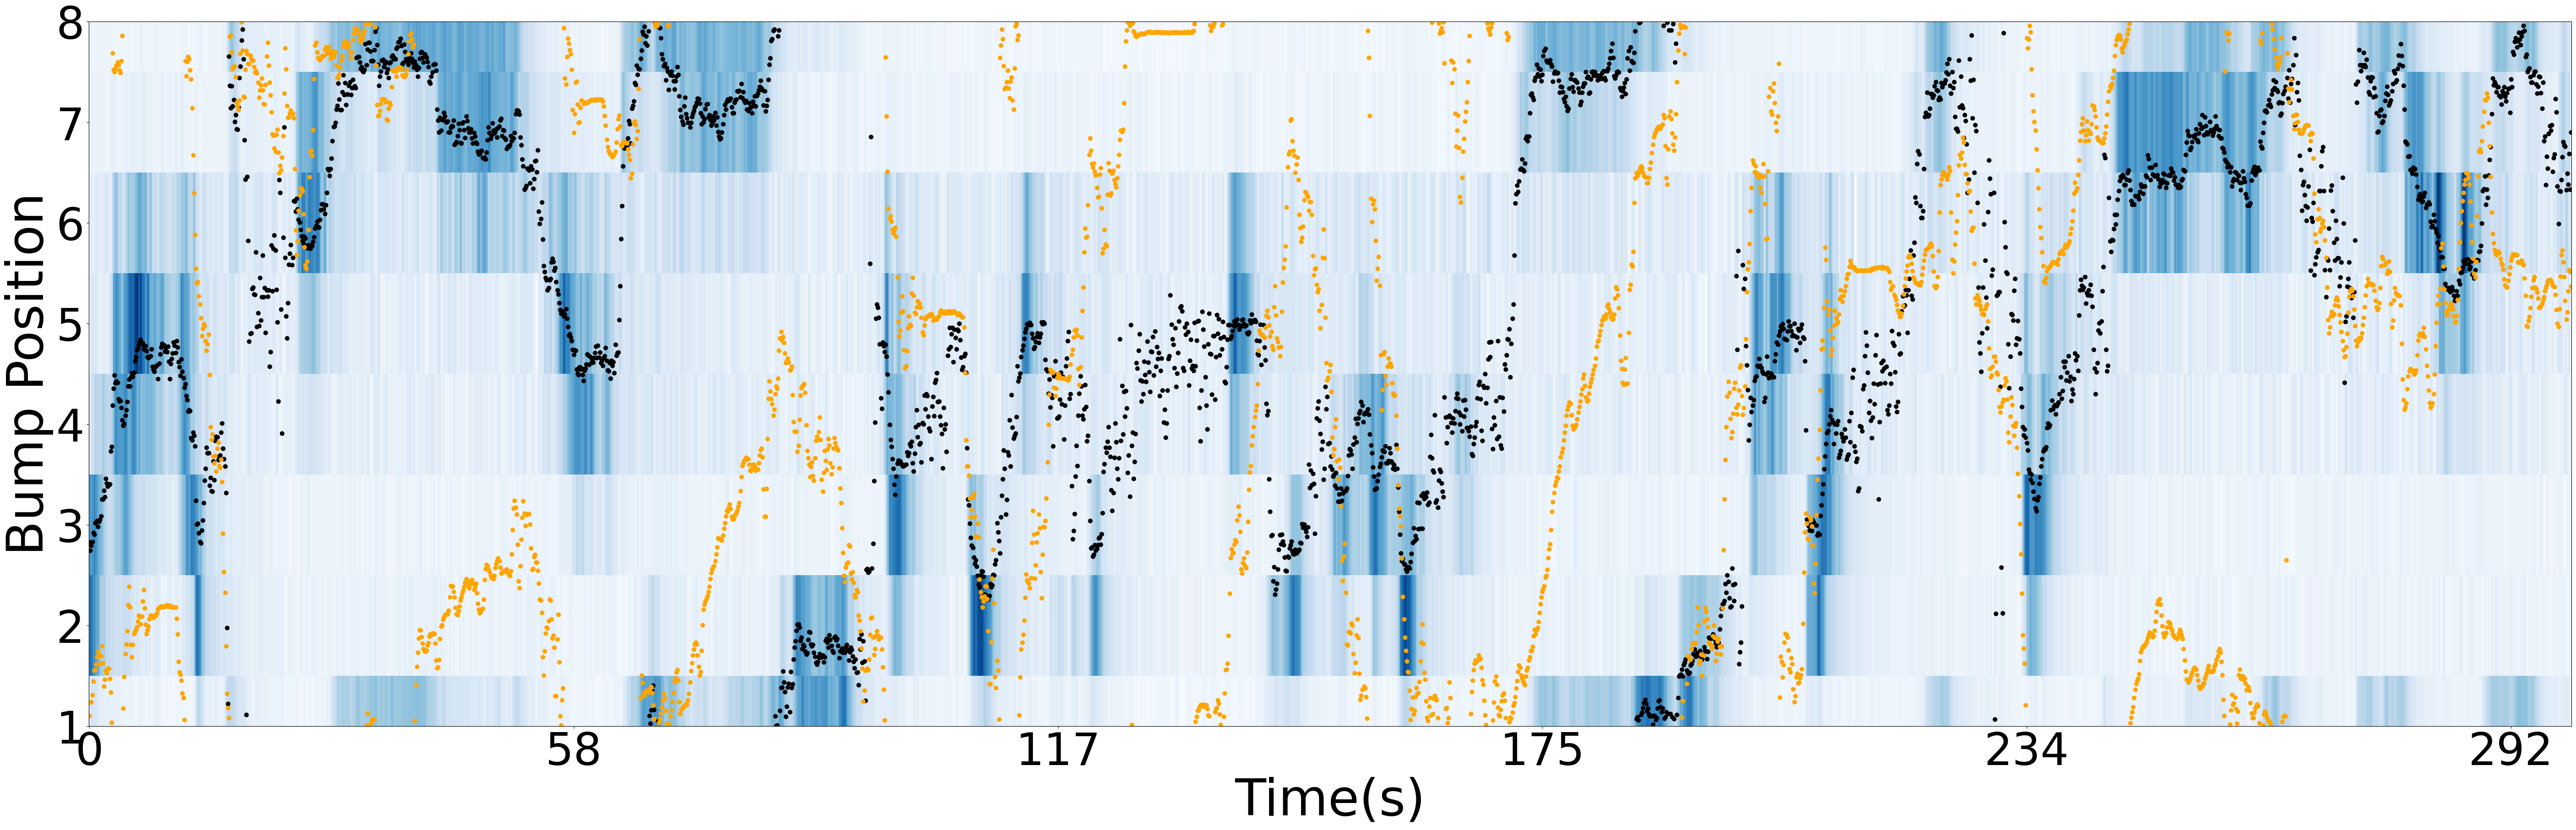

In [25]:
df_dff_in_ROI_normalized_shifted = dff_normalized_8_roi.transpose()
# Reorder the columns
order = [4, 5, 6, 7, 0, 1, 2, 3]
df_dff_in_ROI_normalized_shifted = df_dff_in_ROI_normalized_shifted[order, :]

if dual_imaging == 1:
    df_dff_in_ROI_normalized_shifted_red = dff_normalized_8_roi_red.transpose()
    df_dff_in_ROI_normalized_shifted_red = df_dff_in_ROI_normalized_shifted_red[order, :]

a=plt.figure(figsize= (70,20))
if dual_imaging == 1:
    plt.imshow(df_dff_in_ROI_normalized_shifted_red, aspect= 'auto', interpolation = 'none', cmap = 'Reds', alpha = 1)
    plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues', alpha = 0.7)
else:
    plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', interpolation = 'none', cmap = 'Blues', alpha = 1)
    #plt.imshow(df_dff_in_ROI_normalized_shifted, aspect= 'auto', cmap = 'Blues')

plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)
plt.scatter(np.arange(len(PVA_Angle)),7*(PVA_Angle+180)/2/180, color ='black', s = 40)
#if dual_imaging == 1:
    #plt.scatter(np.arange(len(PVA_Angle_red)),7*(PVA_Angle_red+180)/2/180, color ='orange', s = 40)
if trial_type == 1:
    plt.scatter(np.arange(len(Wrapped_heading_angle)),7*(Wrapped_heading_angle+180)/2/180, color ='red', s = 40)
if trial_type == 0:
    plt.scatter(np.arange(len(Wrapped_heading_angle)),7*(Wrapped_heading_angle+180)/2/180, color ='orange', s = 40)
        
plt.show()
#a.savefig('delta7_Bump_Heatmap__dark', format ='svg')

In [26]:
test = np.mean(df_dff_in_ROI_normalized_shifted,0)

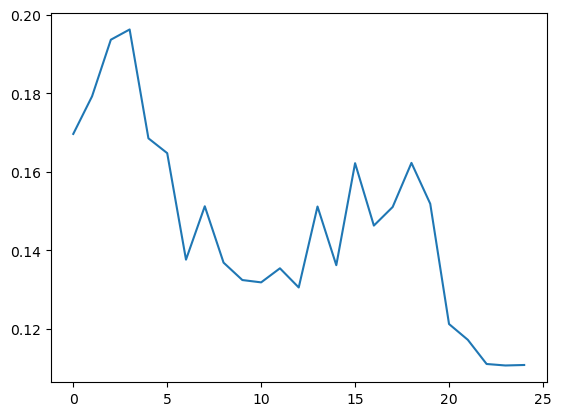

In [27]:
plt.plot(test[175:200])

In [25]:
data=test

In [26]:
data.shape[0]

2600

In [30]:
# Define threshold and minimum frames for stimulation detection
threshold = 0  # Signal threshold to identify low-signal periods
min_duration = 5  # Minimum duration in frames (~1s if volume_rate is 3 Hz)

# Initialize variables
stimulation_periods = []
current_start = None

# Analyze each frame (column-wise) for low-signal periods
for i in range(data.shape[0]):
    # Check if the signal in all rows is below the threshold
    if np.all(data[i] < threshold):
        if current_start is None:
            current_start = i  # Mark the start of a low-signal period
    else:
        if current_start is not None:
            # End of a low-signal period
            if i - current_start >= min_duration:
                stimulation_periods.append((current_start, i - 1))
            current_start = None

# Handle the case where the last period continues until the end
if current_start is not None and data.shape[1] - current_start >= min_duration:
    stimulation_periods.append((current_start, data.shape[1] - 1))

# Display the detected stimulation periods
stimulation_periods

[]

In [37]:
len(stimulation_periods)

4

In [38]:
stimulation_start_index = [pair[0] for pair in stimulation_periods]
stimulation_end_index = [pair[1] for pair in stimulation_periods]

In [39]:
stimulation_end_index 

[434, 509, 900, 2107]

In [34]:
pd_stimulation_periods = pd.DataFrame()
pd_stimulation_periods['stimulation_start_frame'] = stimulation_start_index
pd_stimulation_periods['stimulation_end_frame'] = stimulation_end_index
pd_stimulation_periods.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/EPG_write_in/SS00096_7f_CsCHtdT/for analysis/90-stimulation-index/TQfly542-006-stimulation-frame.csv',encoding = 'utf-8', index=False)

In [25]:
df_dff_in_ROI_normalized_shifted 

array([[0.50145935, 0.66106994, 0.69070214, ..., 0.77552745, 0.74143955,
        0.64678588],
       [0.49450626, 0.56371765, 0.55476165, ..., 0.84054457, 0.81215148,
        0.77759349],
       [0.24696203, 0.29095309, 0.51416126, ..., 0.90667219, 0.91528284,
        0.75736051],
       ...,
       [0.23021678, 0.55054585, 0.69700808, ..., 0.66407547, 0.67648313,
        0.67648313],
       [0.46791954, 0.82830834, 0.76441804, ..., 0.60246289, 0.60246289,
        0.54663341],
       [0.63405103, 0.82651742, 0.78997179, ..., 0.65849939, 0.63393546,
        0.6145537 ]])

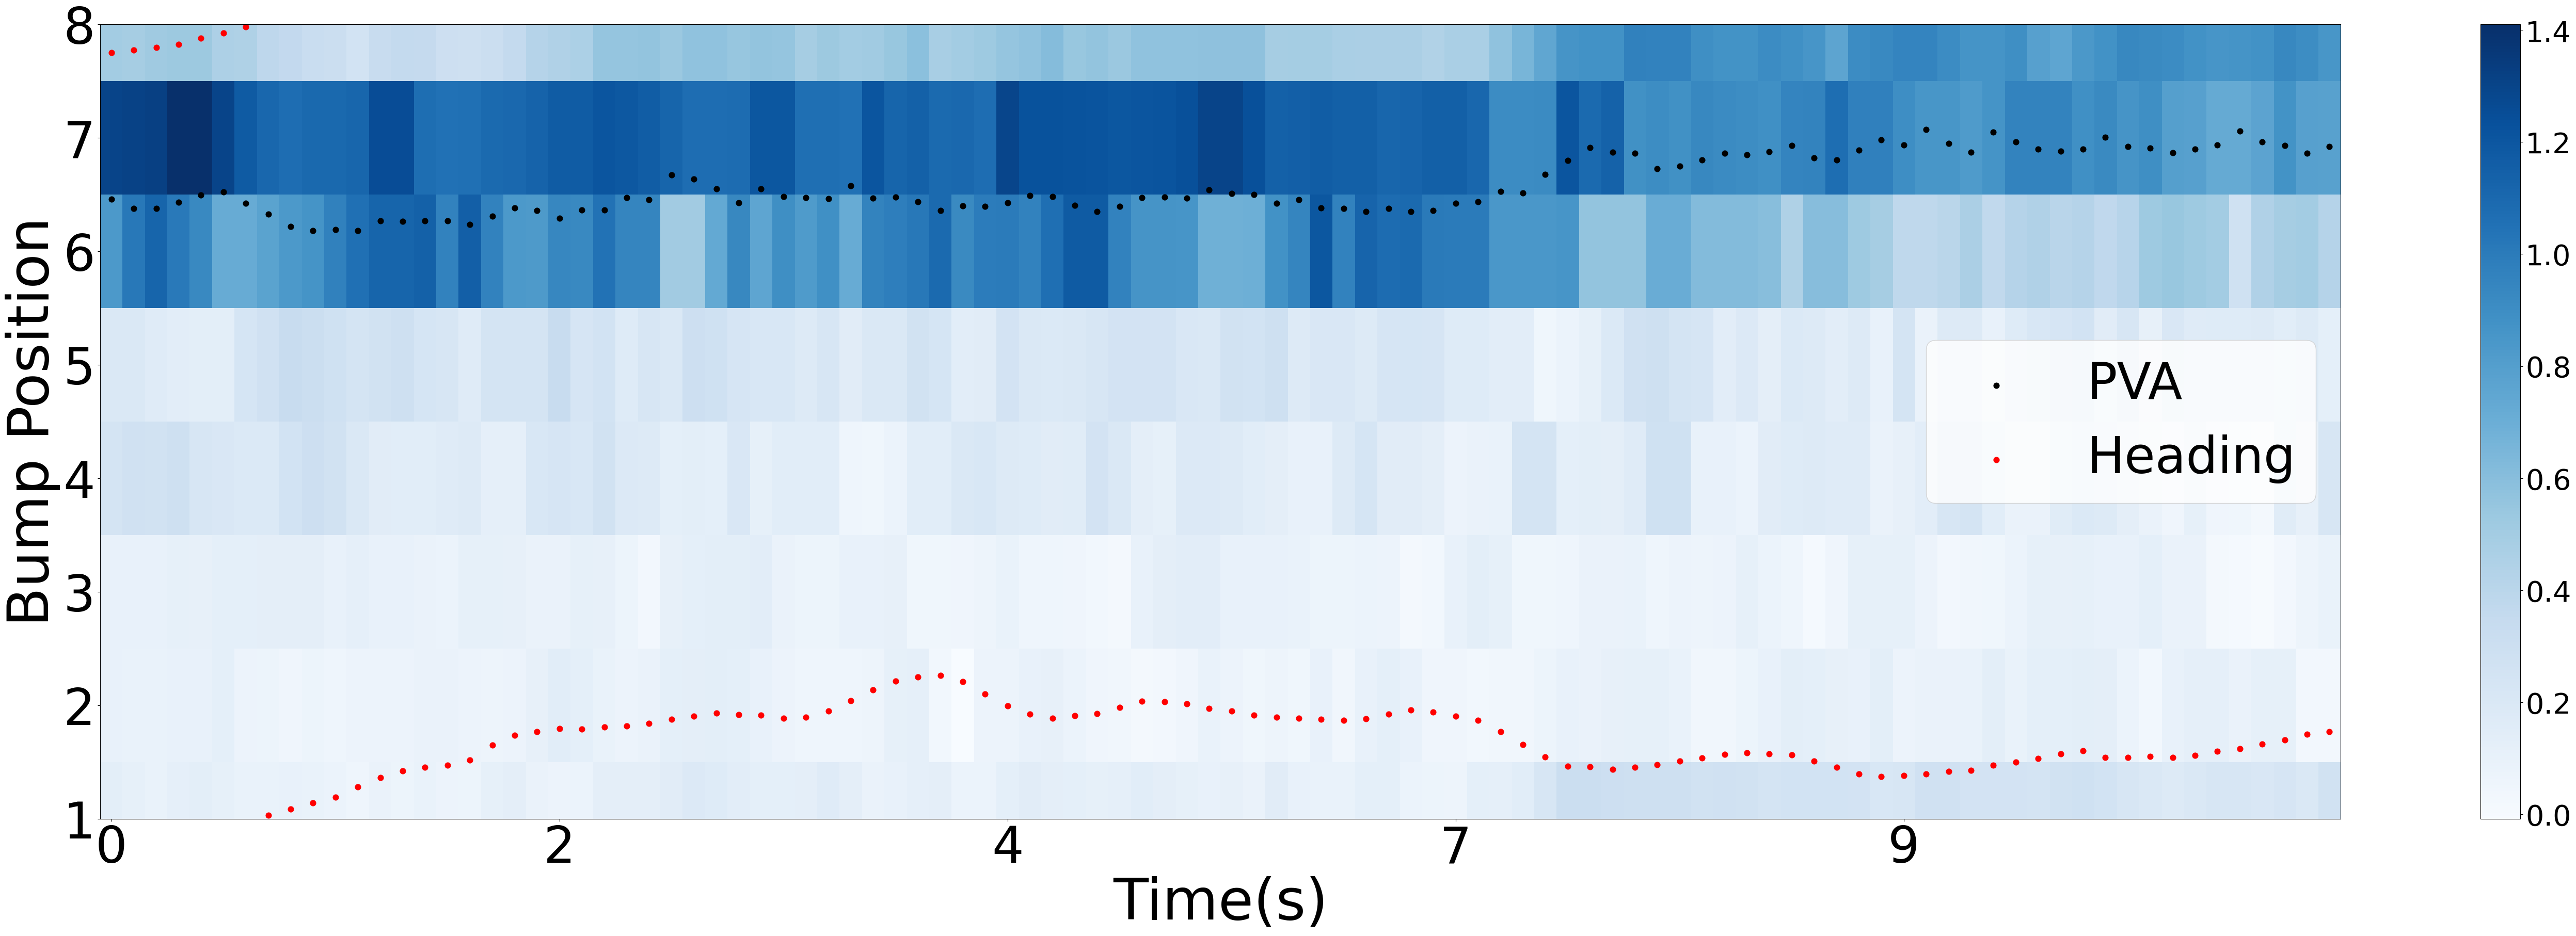

In [28]:
range_start = 2100
range_end = 2200
a= plt.figure(figsize= (70,20))

from scipy.ndimage import gaussian_filter
# Define your smoothing level
sigma = 0.3# Adjust sigma as needed; larger values mean more smoothing
# Apply Gaussian filter to smooth the data
smoothed_data = gaussian_filter(df_dff_in_ROI_normalized_shifted, sigma=sigma)

heatmap = plt.imshow(smoothed_data [:,range_start:range_end], aspect= 'auto', cmap = 'Blues')

# Add color bar with customized settings
colorbar = plt.colorbar(heatmap)  
colorbar.ax.tick_params(labelsize=40)  # Set color bar tick font size
#colorbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])  # Define specific tick positions (adjust as needed)
#colorbar.set_ticklabels(['0', '25%', '50%', '75%', '100%'])  # Set custom tick labels



plt.xlabel('Time(s)', fontsize=80)
plt.ylabel('Bump Position', fontsize=80)
#plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate+ range_start*volume_time, dtype=np.int64), fontsize =70)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
plt.ylim(0,7)
plt.locator_params(axis ='x',nbins = 20)

if bar_jumping == 1: 
    for i in range(len(jumping_frame)):
        if range_start <= jumping_frame[i] <= range_end:
            plt.axvline(x=jumping_frame[i]-range_start, color='purple', linestyle='--', linewidth = 4)

plt.scatter(np.arange(len(PVA_Angle[range_start:range_end])),7*(PVA_Angle[range_start:range_end]+180)/2/180, color ='Black', s = 60,label='PVA')
plt.scatter(np.arange(len(Wrapped_heading_angle[range_start:range_end])),7*(Wrapped_heading_angle[range_start:range_end]+180)/2/180, color ='red', s = 60,label='Heading')
#for i in range(len(persistence_stop_index_and_length)):
    #plt.axvspan(persistence_stop_index_and_length[i][0]-persistence_stop_index_and_length[i][1]-range_start , persistence_stop_index_and_length[i][0]-range_start , color='grey', alpha=0.3)

    
# Add a legend
plt.legend(fontsize=70)    
    
plt.show()
#a.savefig('delta7_syt6s_EPG_shi_241_007_800_1200_Bump_Heatmap_dark', format ='svg')
if dual_imaging == 1:
    a=plt.figure(figsize= (70,20))
    plt.imshow(df_dff_in_ROI_normalized_shifted_red[:,range_start:range_end], aspect= 'auto', cmap = 'Greens',alpha = 1)
    plt.xlabel('Time(s)', fontsize=80)
    plt.ylabel('Bump Position', fontsize=80)
    plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =70)
    plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=70)
    plt.ylim(0,7)
    plt.locator_params(axis ='x',nbins = 20)
    plt.scatter(np.arange(len(PVA_Angle_red[range_start:range_end])),7*(PVA_Angle_red[range_start:range_end]+180)/2/180, color ='Black', s = 40)
    plt.scatter(np.arange(len(Wrapped_heading_angle[range_start:range_end])),7*(Wrapped_heading_angle[range_start:range_end]+180)/2/180, color ='red', s = 40)
    if bar_jumping == 1: 
        for i in range(len(jumping_frame)):
            if range_start <= jumping_frame[i] & jumping_frame[i]  <= range_end:
                plt.axvline(x=jumping_frame[i]-range_start, color='purple', linestyle='--',linewidth = 4)
    plt.show()

In [29]:
len(persistence_stop_index_and_length)

4

In [30]:
# Peak shift (might still be useful)
df_dff_in_ROI_normalized_shifted_peak_centered = np.zeros((len(df_dff_in_ROI_normalized_shifted), len(df_dff_in_ROI_normalized_shifted[0])))
Wrapped_heading_angle_8_ROI = 7*(Wrapped_heading_angle+180)/2/180
Wrapped_heading_angle_shifted = np.zeros(len(Wrapped_heading_angle_8_ROI ))
shifted_by_all = []

for i in range(len(df_dff_in_ROI_normalized_shifted[0])):
    original_order = [0,1,2,3,4,5,6,7]
    current_peak = np.argmax(df_dff_in_ROI_normalized_shifted[:,i])
    shift_by = current_peak - 3
    shifted_order = original_order[shift_by % len(original_order):] + original_order[:shift_by % len(original_order)]
    df_dff_in_ROI_normalized_shifted_peak_centered[:,i] = df_dff_in_ROI_normalized_shifted[shifted_order,i]
    shifted_by_all.append(shift_by)
    
    
    new_angle_discret = Wrapped_heading_angle_8_ROI[i] - shift_by
    if new_angle_discret < 0:
        new_angle_discret = 8 + new_angle_discret
    if new_angle_discret > 7:
        new_angle_discret = new_angle_discret - 8
   
    
    Wrapped_heading_angle_shifted[i]  = new_angle_discret
    
Wrapped_heading_angle_discretized_shifted = np.round(Wrapped_heading_angle_shifted)

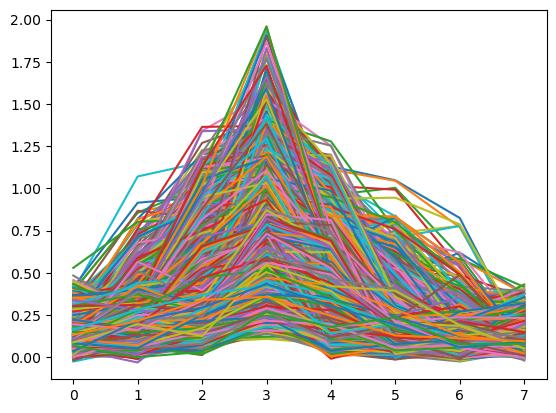

In [31]:
for i in range (len(df_dff_in_ROI_normalized_shifted_peak_centered[0])):
    plt.plot(df_dff_in_ROI_normalized_shifted_peak_centered[:,i])

plt.show()

In [32]:
df_dff_in_ROI_normalized_shifted_peak_centered.shape

(8, 2563)

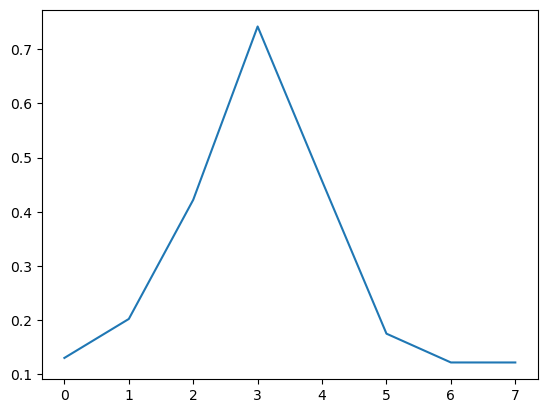

In [33]:
test = np.mean(df_dff_in_ROI_normalized_shifted_peak_centered, axis=1)
plt.plot(test)
plt.show()

In [34]:
test

array([0.13013179, 0.2020415 , 0.42193088, 0.74179765, 0.45677826,
       0.17490052, 0.12177141, 0.1217418 ])

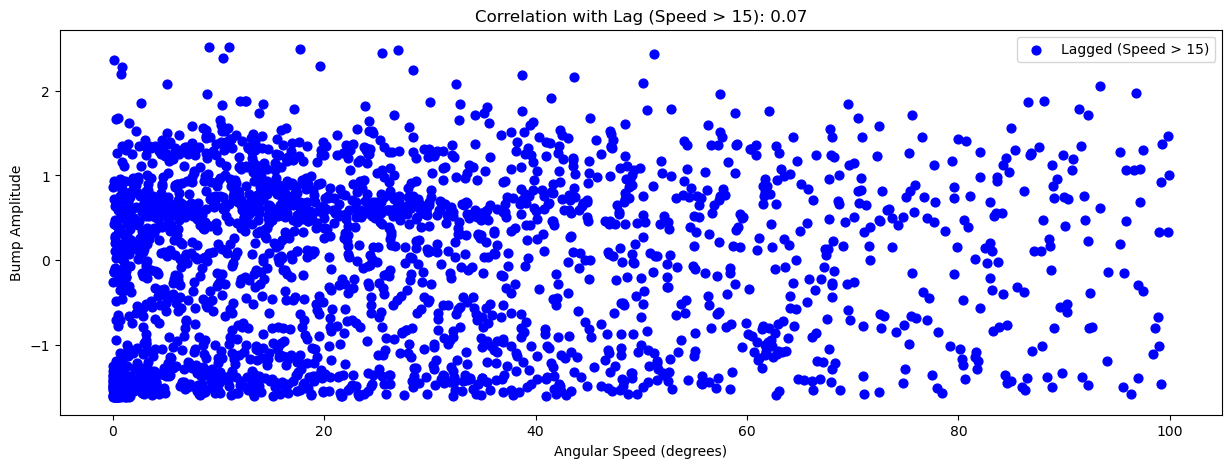

In [35]:
from scipy.signal import correlate

Bump_amplitude_smooth_for_speed_cor = gaussian_filter1d(bump_amplitude_dff_normalized_v3, sigma =6)
Bump_amplitude_z_smooth_for_speed_cor = zscore(Bump_amplitude_smooth_for_speed_cor)


# Calculate cross-correlation within the allowed lags range
cross_corr = correlate(angular_speed_degrees, Bump_amplitude_z_smooth_for_speed_cor, mode='full')
lags = correlation_lags(angular_speed_degrees.size,  Bump_amplitude_z_smooth_for_speed_cor.size, mode="full")
                                  
#find the middle index to consider the frame on both side till max shift frame (1s)
max_shift_frame = int(volume_rate)
middle_index = int(len(lags)/2)
lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
correlation_short = cross_corr[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
lag = lags_short[np.argmax(correlation_short)]
if lag > 0:
    lag = lags_short[np.argmax(correlation_short[0:int((len(correlation_short)-1)/2+1)])]
lag = int(-0.4/volume_time)
    
# Apply the lag only to Bump_amplitude_z_smooth_for_speed_cor
    
#shift back tne bump_amplitude by drop the lag frame at the beginning
lagged_Bump_amplitude_z_smooth_for_speed_cor = Bump_amplitude_z_smooth_for_speed_cor[-lag:]
angular_speed_degrees_shifted = angular_speed_degrees[:len(lagged_Bump_amplitude_z_smooth_for_speed_cor)]
# Create a mask for data points where Forward_speed_degrees > 15
mask = (angular_speed_degrees_shifted > 0) & (angular_speed_degrees_shifted < 100)

# Apply the mask to both time series
masked_angular_speed = angular_speed_degrees_shifted[mask]
masked_lagged_Bump_amplitude_z_smooth_for_speed_cor = lagged_Bump_amplitude_z_smooth_for_speed_cor[mask]

# Now you can calculate the correlation with lag accounted for and the mask
correlation_coefficient = np.corrcoef(masked_angular_speed, masked_lagged_Bump_amplitude_z_smooth_for_speed_cor)[0, 1]

# Plot the original and lagged time series for visualization
plt.figure(figsize=(15, 5))
plt.scatter(masked_angular_speed, masked_lagged_Bump_amplitude_z_smooth_for_speed_cor, color='blue', s=40, label='Lagged (Speed > 15)')
plt.legend()
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Bump Amplitude')
plt.title(f'Correlation with Lag (Speed > 15): {correlation_coefficient:.2f}')
plt.show()

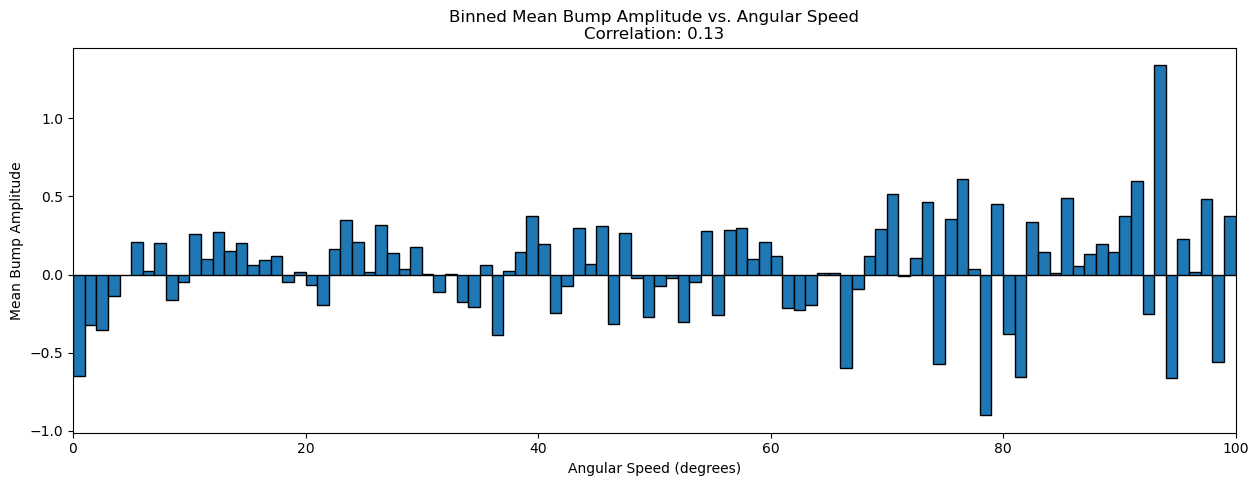

In [36]:


# Define the bin edges with a bin width of 5
bin_width = 1
bin_edges = np.arange(0, 100 + bin_width, bin_width)

# Use scipy's binned_statistic to calculate the mean bump amplitude for each bin
binned_stats = binned_statistic(angular_speed_degrees_shifted, lagged_Bump_amplitude_z_smooth_for_speed_cor, statistic='mean', bins=bin_edges)

# Extract the mean bump amplitude and bin centers
mean_bump_amplitude_per_bin = binned_stats.statistic
bin_centers = binned_stats.bin_edges[:-1] + 0.5 * bin_width

# Exclude bins with no data points
valid_bins = ~np.isnan(mean_bump_amplitude_per_bin)

# Calculate the correlation between mean bump amplitude and bin centers for valid bins
correlation_coefficient = np.corrcoef(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins])[0, 1]

# Plot the binned mean bump amplitude against the angular speed for valid bins
plt.figure(figsize=(15, 5))
plt.bar(bin_centers[valid_bins], mean_bump_amplitude_per_bin[valid_bins], width=bin_width, align='center', edgecolor='black')
plt.xlim(0, np.max(bin_edges))  # Set the limit for angular speed
plt.xlabel('Angular Speed (degrees)')
plt.ylabel('Mean Bump Amplitude')
plt.title(f'Binned Mean Bump Amplitude vs. Angular Speed\nCorrelation: {correlation_coefficient:.2f}')
plt.show()

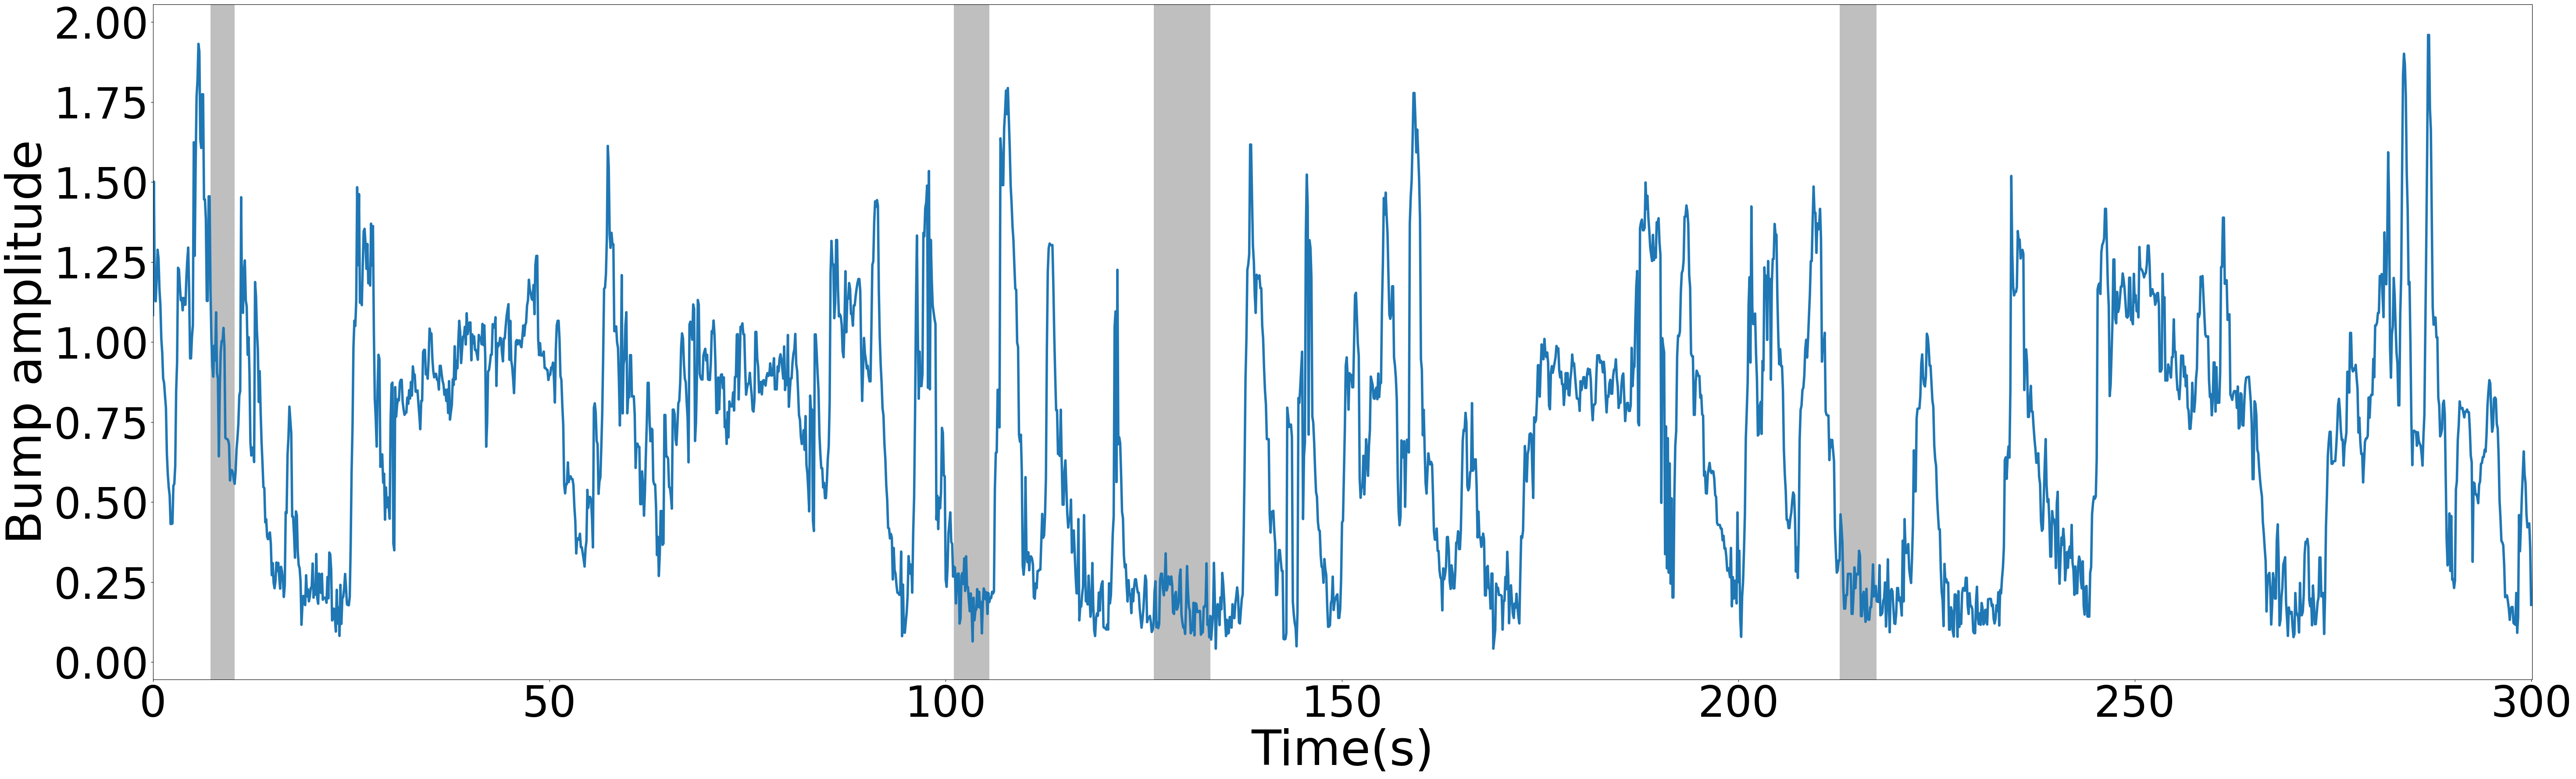

In [37]:
plt.figure(figsize= (70,20))
bump_amplitude_dff_normalized_v4 = calcualteBumpAmplitude_V4(bump_amplitude_dff_normalized_v3, dff_normalized_8_roi, PVA_Unwrapped_Radian, persistence_stop_index_and_length)
plt.plot(time_array_imaging,bump_amplitude_dff_normalized_v3,linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump amplitude', fontsize=80)
plt.show()

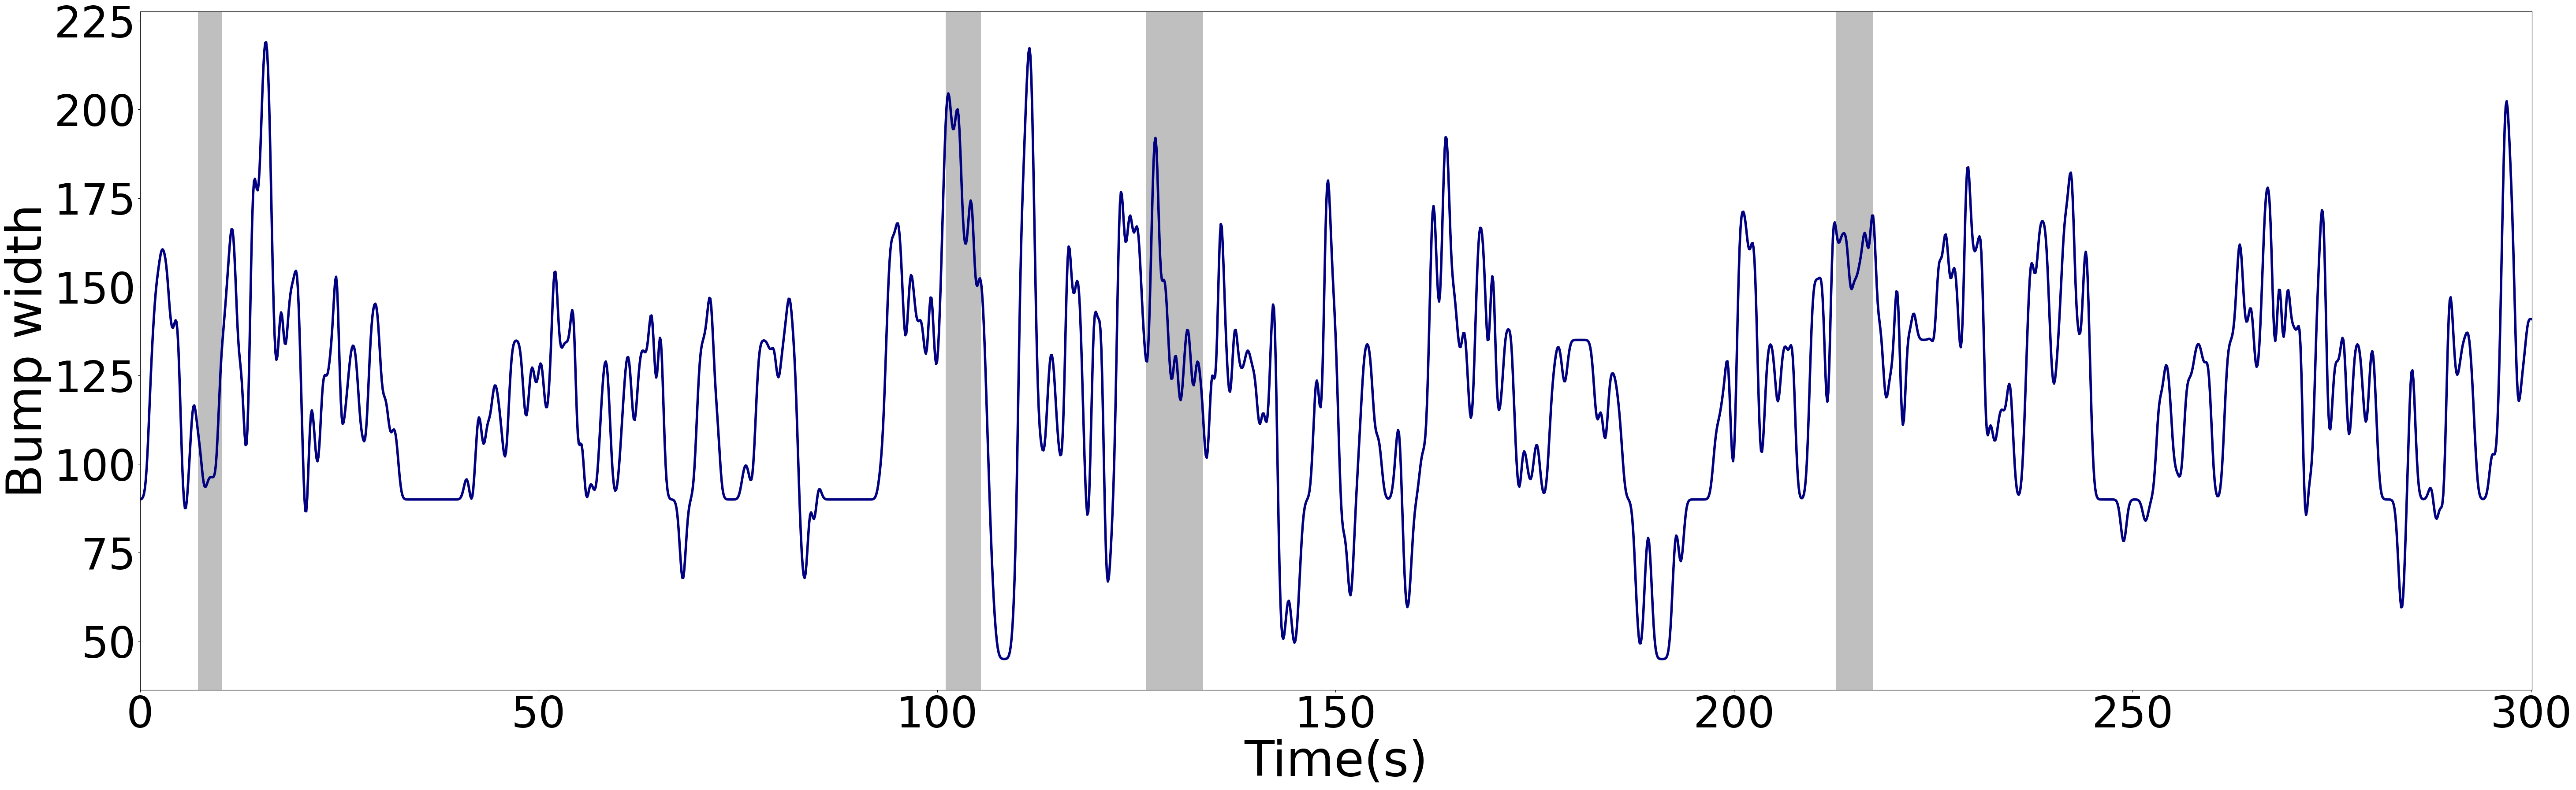

In [38]:
bump_width= calculateBumpWidth_v1(dff_normalized_8_roi,8)
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,gaussian_filter1d(bump_width, sigma =3),linewidth =4, color ='navy')
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('Bump width', fontsize=80)
plt.show()
plt.show()

In [45]:
if bar_jumping == 1:
    plt.figure(figsize= (70,20))
    plt.plot(time_array_imaging,PVA_strength/PVA_strength_red,color = 'r',linewidth =4)
    for i in range(len(persistence_stop_index_and_length)):
        plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
    plt.xlabel('Time(s)', fontsize=80) 
    plt.xticks(fontsize=70)
    plt.yticks(fontsize=70)
    plt.xlim(0,volume_cycle*volume_time)
    plt.ylabel('PVA strength', fontsize=80)
    plt.ylim(0,10)
    plt.show()

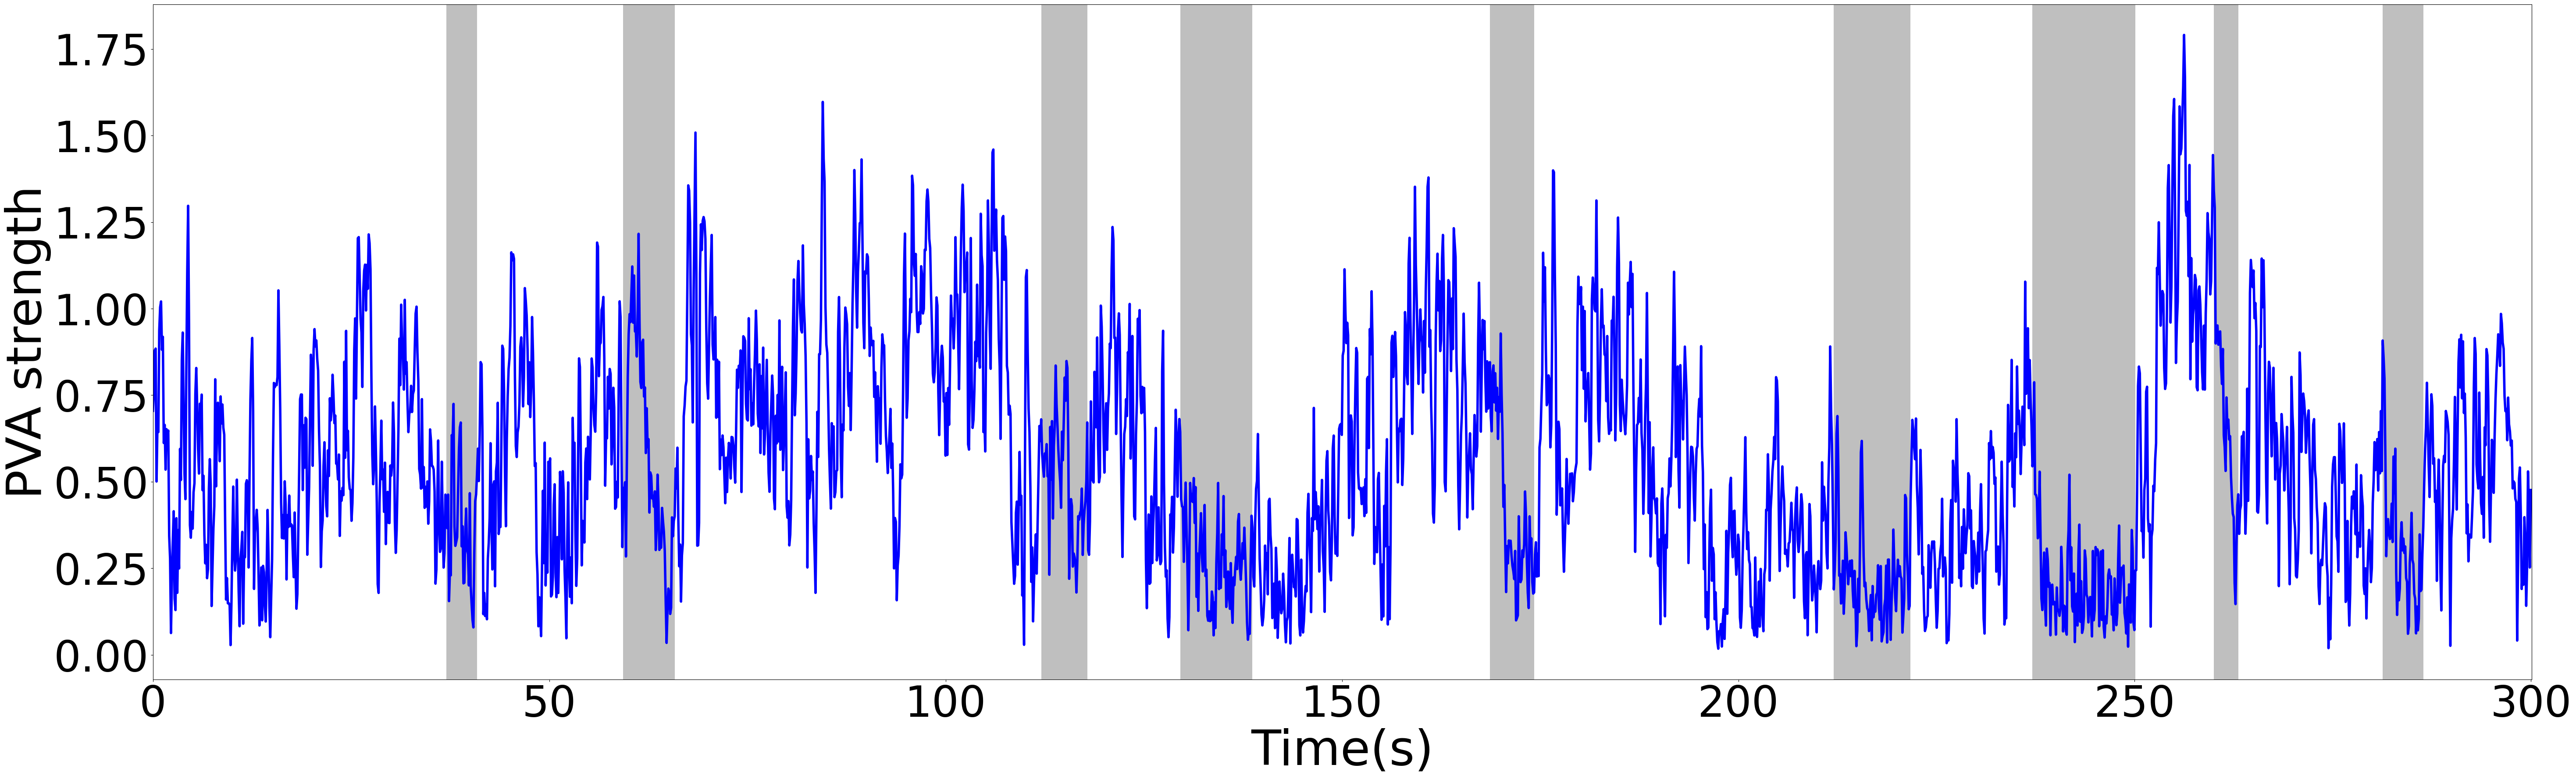

In [50]:
plt.figure(figsize= (70,20))
plt.plot(time_array_imaging,PVA_strength,color = 'b',linewidth =4)
#plt.plot(time_array_imaging,PVA_strength_red,color = 'r',linewidth =4)
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan((persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1])*volume_time, persistence_stop_index_and_length[i,0]*volume_time, color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.xlabel('Time(s)', fontsize=80)
plt.xticks(fontsize=70)
plt.yticks(fontsize=70)
plt.xlim(0,volume_cycle*volume_time)
plt.ylabel('PVA strength', fontsize=80)
plt.show()

In [35]:
np.mean(PVA_strength)

0.9405520051616889

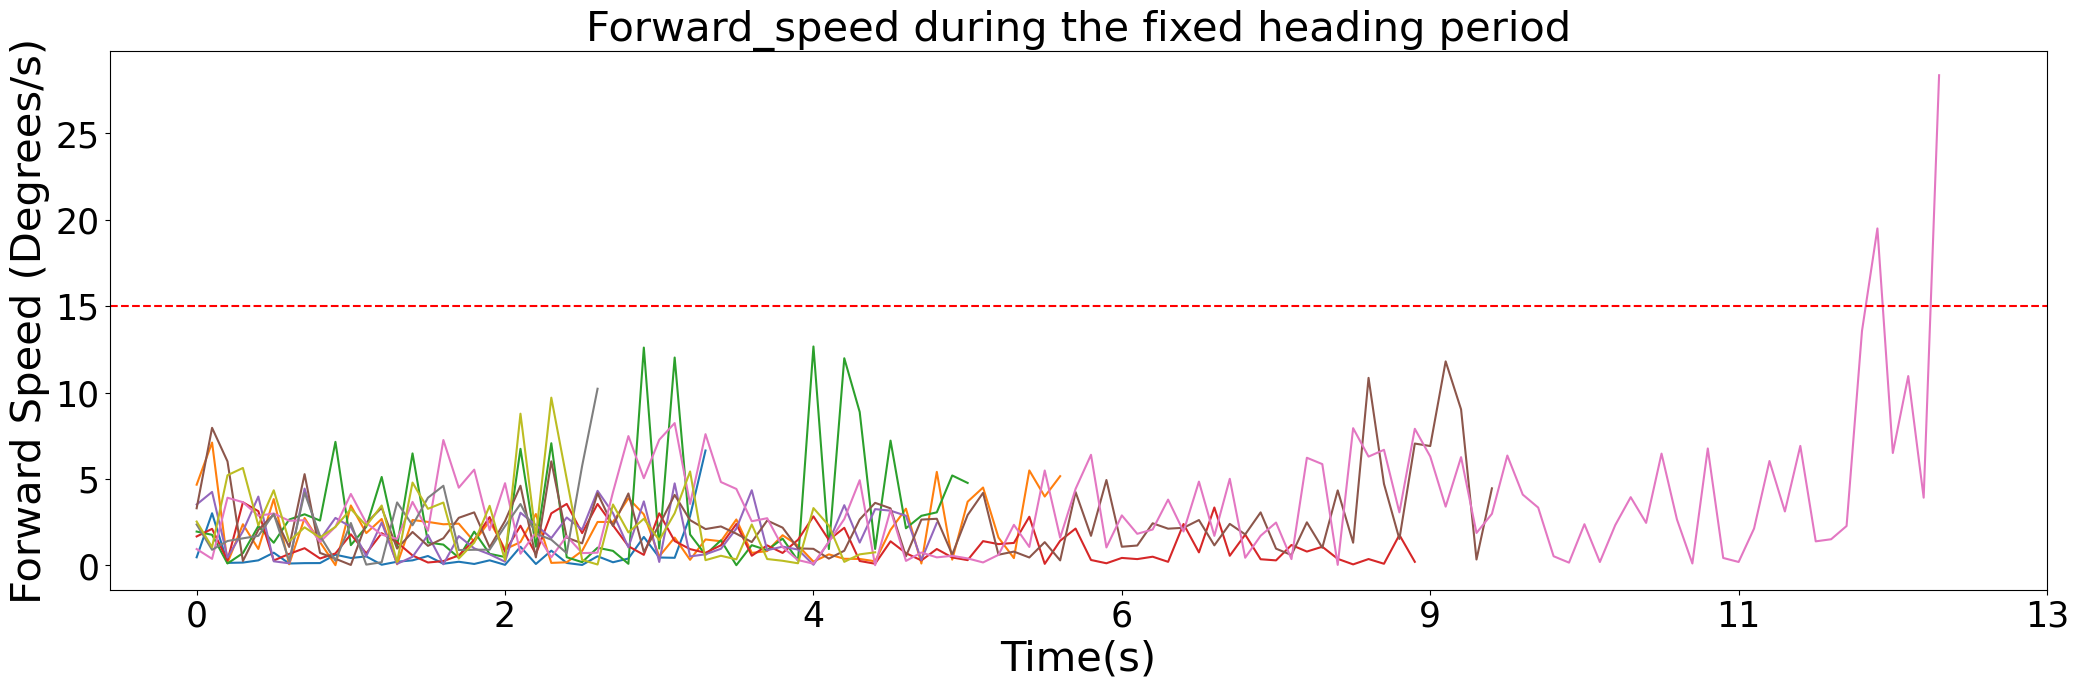

In [46]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(Forward_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Forward_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Forward Speed (Degrees/s)', fontsize=30)
plt.show()
    

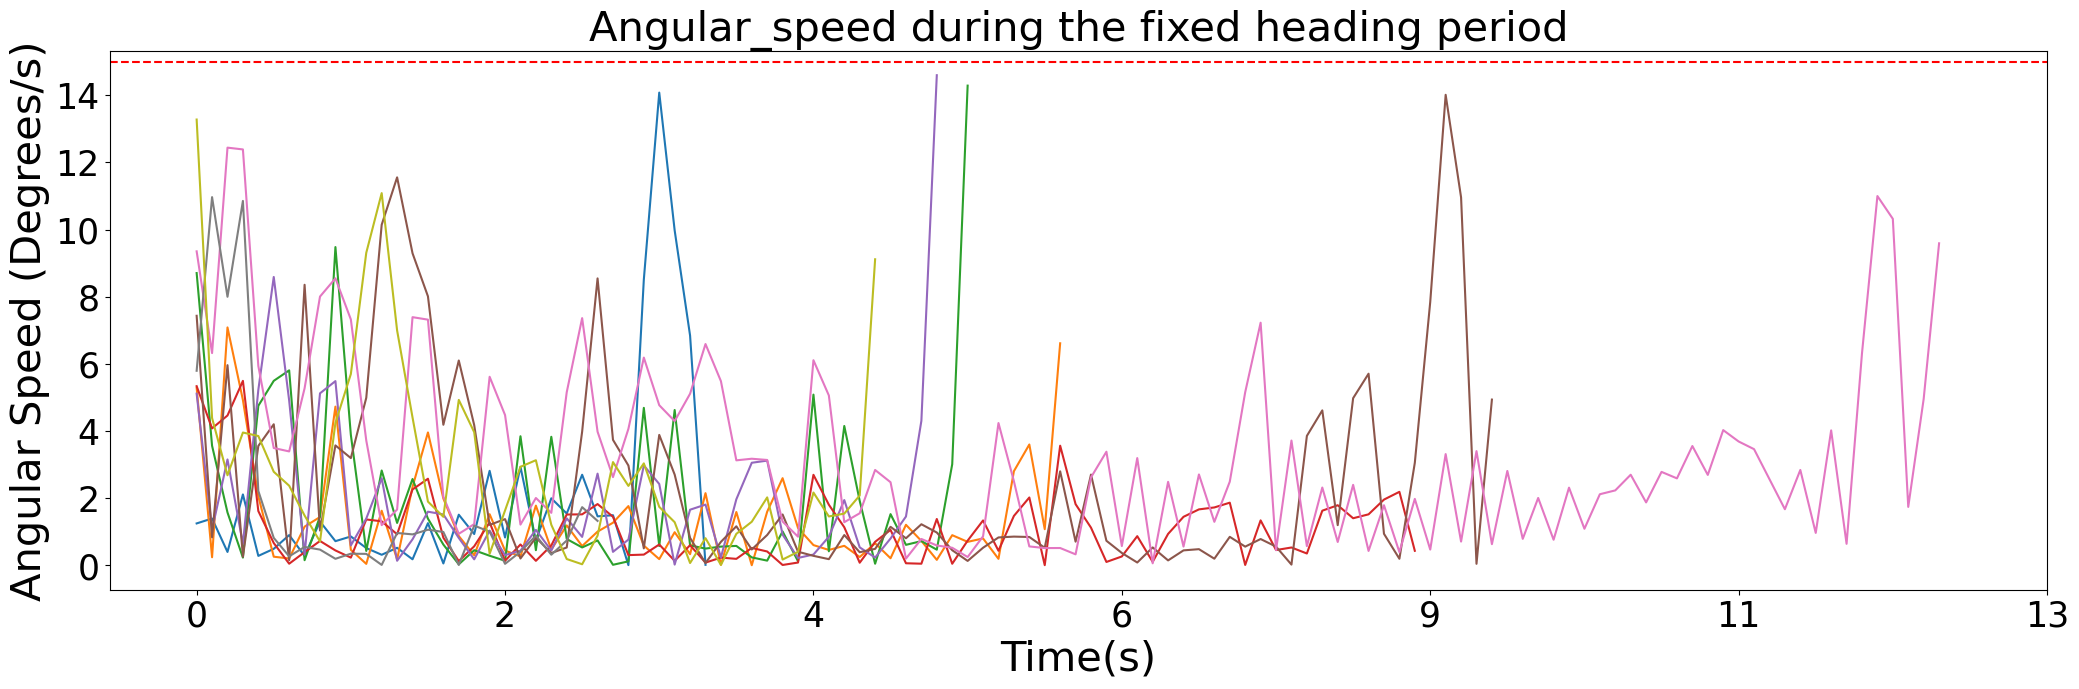

In [47]:
plt.figure(figsize= (25,7))
for i in range(len(persistence_stop_index_and_length)):
    plt.plot(angular_speed_degrees[persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1]+1:persistence_stop_index_and_length[i,0]+1])
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.title('Angular_speed during the fixed heading period', fontsize =30)
plt.axhline(y= 15, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=30)
plt.yticks(fontsize=25)
plt.ylabel('Angular Speed (Degrees/s)', fontsize=30)
plt.show()
    

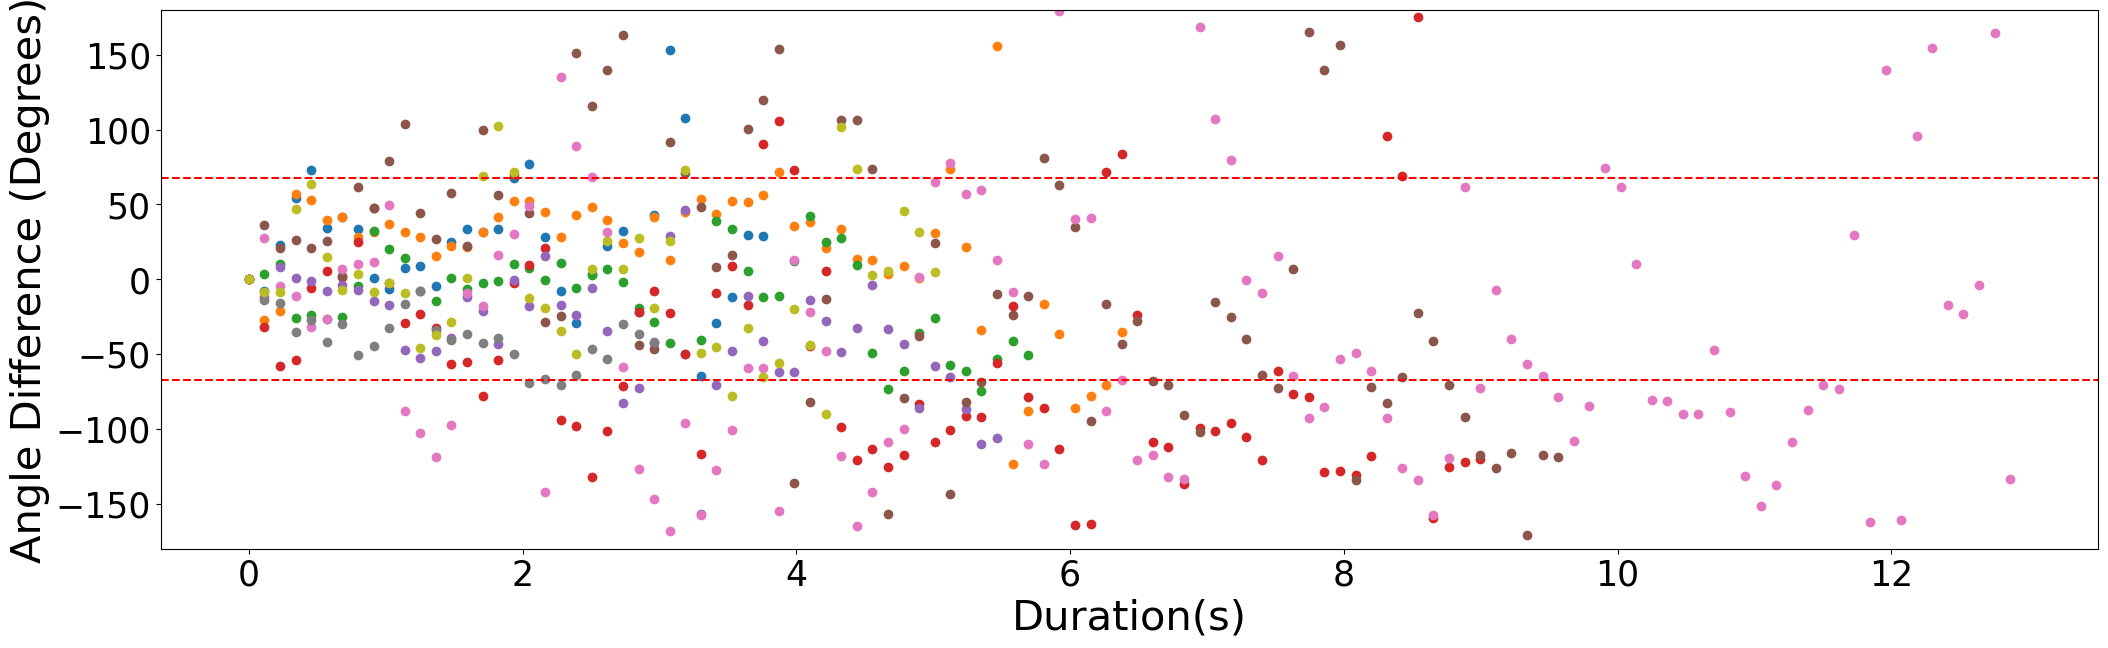

In [48]:
#Calculate annd plot difference throughout the stop period
difference_during_stop = []
current_difference_during_stop = []
current_forward_speed_during_stop = []
forward_speed_during_stop =[]
plt.figure(figsize= (25,7))
for current_index in range(len(persistence_stop_index_and_length)):
    current_stop_PVA = PVA_Angle[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
    current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
    current_difference_during_stop = PVA_Angle[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
    current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
    #Modify the value so angle difference will never be different more than 180 degrees
    for j in range(len(current_difference_during_stop)):
        if np.abs(current_difference_during_stop[j]) > 180:
            if current_difference_during_stop[j] < 0:
                current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
            else:
                current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
    
    difference_during_stop.append(current_difference_during_stop)
    forward_speed_during_stop.append(current_forward_speed_during_stop)
    current_time = np.arange(len(current_difference_during_stop))/volume_rate
    plt.scatter(current_time,current_difference_during_stop)

max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
#plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/volume_rate, dtype=np.int64), fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-180,180)
plt.show()
    

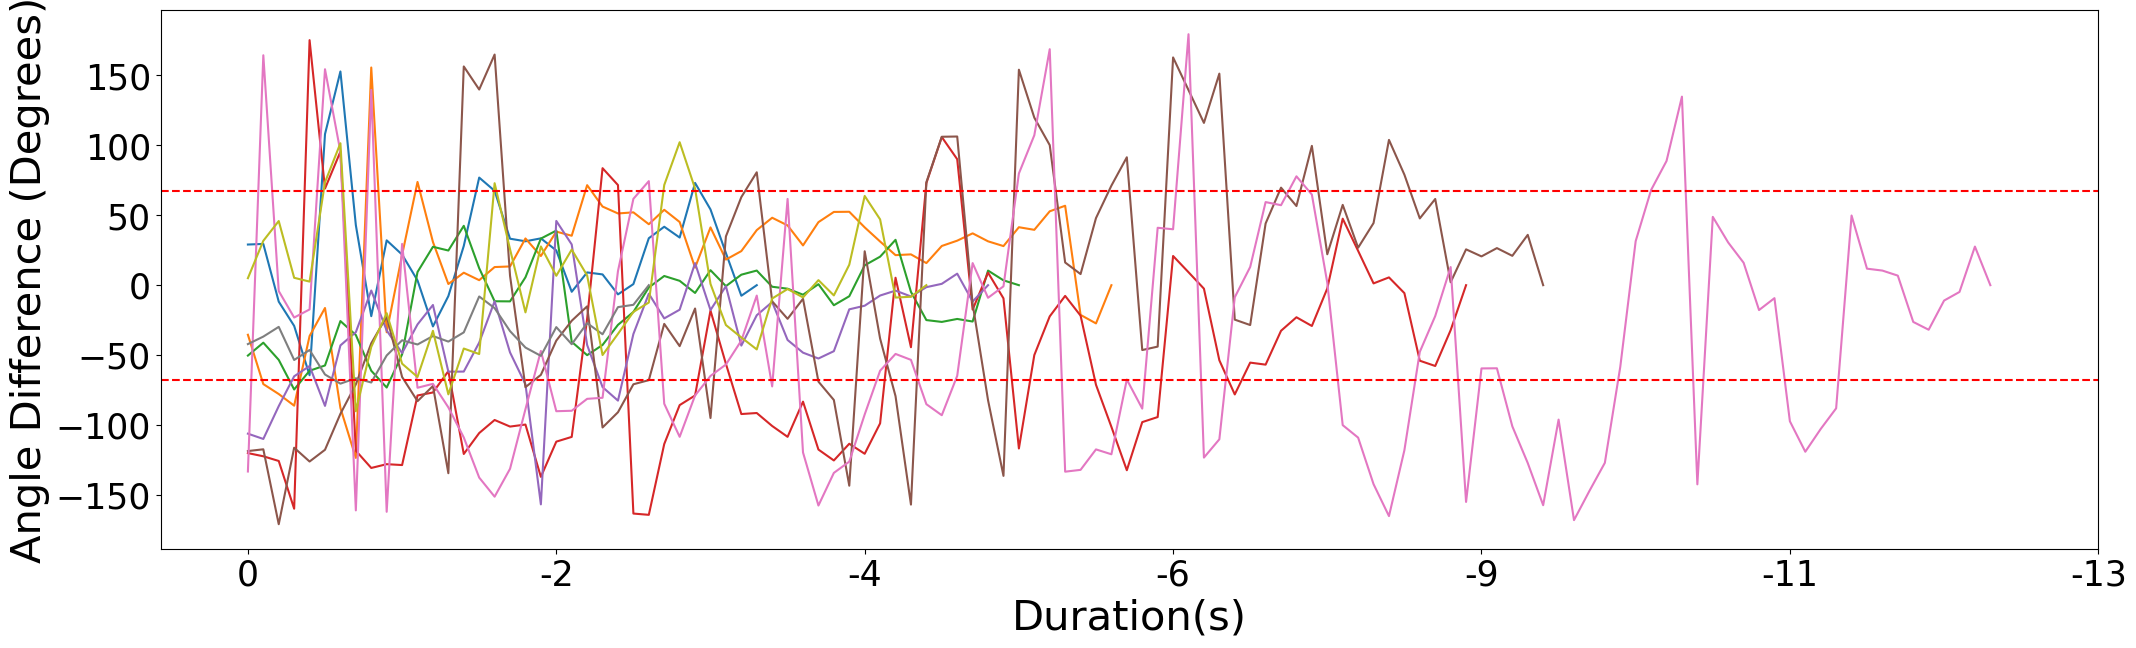

In [49]:
# Plot the reverse of difference during fixed heading period (align at the restart)
plt.figure(figsize= (25,7))
for i in range(len(difference_during_stop)):
    plt.plot(np.flip(difference_during_stop[i]))
             
max_length = 0
for i in range(len(difference_during_stop)):
    if max_length < len(difference_during_stop[i]):
        max_length = len(difference_during_stop[i])

time_array_PVA_difference_stop = np.arange(max_length)/volume_rate
plt.axhline(y= 67.5, color = 'r',linestyle ='--')
plt.axhline(y= -67.5, color = 'r',linestyle ='--')
plt.ylabel('Angle Difference (Degrees)', fontsize=30)
plt.xlabel('Duration(s)',fontsize =30)
plt.xticks(ticks=plt.xticks()[0][1:], labels=np.array(plt.xticks()[0][1:]/-volume_rate, dtype=np.int64), fontsize=25)
plt.yticks(fontsize=25)
plt.show()

In [44]:
PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle, volume_time=volume_time)
PVA_angle_at_stop.insert(0,'FlyTrial','TQfly201-005')
PVA_angle_at_stop.insert(1,'Genotype','SS00078>sytGCaMP7f')
PVA_angle_at_stop.insert(2,'TrialType','cl')
PVA_angle_at_stop

FlyTrial            Genotype TrialType  Period_duration   
0  TQfly201-005  SS00078>sytGCaMP7f        cl          3.61152  \
1  TQfly201-005  SS00078>sytGCaMP7f        cl          3.11904   
2  TQfly201-005  SS00078>sytGCaMP7f        cl         12.80448   
3  TQfly201-005  SS00078>sytGCaMP7f        cl          9.35712   
4  TQfly201-005  SS00078>sytGCaMP7f        cl          5.17104   
5  TQfly201-005  SS00078>sytGCaMP7f        cl          3.20112   
6  TQfly201-005  SS00078>sytGCaMP7f        cl          5.17104   
7  TQfly201-005  SS00078>sytGCaMP7f        cl         31.10832   
8  TQfly201-005  SS00078>sytGCaMP7f        cl          3.20112   
9  TQfly201-005  SS00078>sytGCaMP7f        cl         20.60208   

   PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0        17.430437       52.946025                 59.567665  \
1       -89.549331      -82.037492                105.671029   
2       158.737980       95.044273                 85.550281   
3       -60.649764     -105.462919               -104.034970   
4       124.570061     -143.397526               -124.680973   
5        -3.645611       -1.364280                 26.251692   
6      -104.569986     -108.675121                -86.438174   
7       166.905693      -57.960028                -52.132775   
8        32.727158      -59.092879                -68.524800   
9      -106.940701       54.833596                 49.591989   

   PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart   
0                 57.624004      59.488590              46.328045  \
1                -76.982299    -127.304956            -119.580802   
2                105.065904     116.058406              82.272414   
3               -119.168139    -112.781229            -112.458056   
4               -130.523954    -155.309678            -117.472845   
5                 33.191383      15.644171              12.841058   
6                -83.145048    -100.789565            -116.559842   
7                -58.879079     109.435604             -71.666803   
8                145.067593      30.885671              49.331649   
9                 27.980210     -89.221519              37.561804   

   PVA_3s_after_stop  PVA_5s_after_stop  PVA_10s_after_stop   
0          50.493526                NaN                 NaN  \
1         -59.922011                NaN                 NaN   
2         106.377933         121.053644           82.345645   
3        -140.784903        -108.284340                 NaN   
4        -121.075437        -124.680973                 NaN   
5          26.251692                NaN                 NaN   
6        -111.766071         -86.438174                 NaN   
7         168.360132         140.654559           93.296483   
8         -68.524800                NaN                 NaN   
9        -124.188996        -104.422510         -100.183718   

   PVA_20s_after_stop  PVA_35s_after_stop  PVA_60s_after_stop  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  
5                 NaN                 NaN                 NaN  
6                 NaN                 NaN                 NaN  
7           92.737460                 NaN                 NaN  
8                 NaN                 NaN                 NaN  
9           -5.989094                 NaN                 NaN

In [45]:
Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
Forward_speed_at_stop

forward_speed_before_stop  forward_speed_at_restart   
0                   2.428721                 15.616771  \
1                   2.258799                  3.575356   
2                   1.951293                  2.256810   
3                   1.815033                  1.579425   
4                   5.838493                  4.162761   
5                   4.025250                 34.108215   
6                   0.879872                  0.990807   
7                   3.409770                  4.517186   
8                   1.895108                  2.415731   
9                   2.021547                 30.032967   

   forward_speed_100ms_before_restart  forward_speed_500ms_before_restart   
0                            6.030339                            7.343244  \
1                            0.824557                            1.738102   
2                            3.637114                            0.477272   
3                            0.939667                            2.824052   
4                           15.592628                            1.912403   
5                           15.697221                            2.004682   
6                            1.754057                            0.436387   
7                            2.389767                            1.148351   
8                            1.910948                            5.290022   
9                            0.145452                            0.766958   

   forward_speed_in_middle  forward_speed_2s_before_restart   
0                12.043239                         3.747154  \
1                 5.211515                         2.008873   
2                 8.622698                         0.763682   
3                16.937095                         3.573190   
4                10.999000                         0.685443   
5                 0.636119                         1.694361   
6                 0.316756                         0.569511   
7                 2.670841                         0.955186   
8                 1.764792                         1.715070   
9                 2.235848                         3.397815   

   forward_speed_3s_after_stop  forward_speed_5s_after_stop   
0                     1.763365                          NaN  \
1                     5.584046                          NaN   
2                     2.889142                     1.532872   
3                     0.031117                     2.845487   
4                     0.954340                    15.592628   
5                    15.697221                          NaN   
6                     0.613980                     1.754057   
7                     0.751431                     1.384822   
8                     1.910948                          NaN   
9                     0.480191                     0.595660   

   forward_speed_10s_after_stop  forward_speed_20s_after_stop   
0                           NaN                           NaN  \
1                           NaN                           NaN   
2                      0.222185                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   
5                           NaN                           NaN   
6                           NaN                           NaN   
7                      0.218137                      1.142779   
8                           NaN                           NaN   
9                      0.399133                      2.322383   

   forward_speed_35s_after_stop  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
5                           NaN  
6                           NaN  
7                           NaN  
8                           NaN  
9                           NaN

In [47]:
Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude, volume_time=volume_time)
Bump_amplitude_at_stop

bump_amplitude_before_stop  bump_amplitude_at_restart   
0                    0.322455                   0.657483  \
1                    0.335094                   0.290237   
2                    0.809339                   0.609963   
3                    0.226023                   0.570405   
4                    0.388342                   0.651167   
5                    1.027642                   0.747664   
6                    0.484088                   0.670528   
7                    0.679670                   0.277506   
8                    0.349951                   0.464076   
9                    0.644540                   0.419206   

   bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                             0.456807                             0.888133  \
1                             0.249735                             0.354772   
2                             0.676174                             0.730481   
3                             0.559635                             0.555754   
4                             0.539148                             0.480359   
5                             0.929269                             0.672201   
6                             0.663618                             0.434689   
7                             0.221056                             0.285034   
8                             0.365415                             0.408468   
9                             0.413550                             0.387954   

   bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                  0.774233                          0.601600  \
1                  0.317618                          0.554813   
2                  0.734217                          0.874429   
3                  0.449298                          0.704155   
4                  0.356105                          0.484415   
5                  0.495438                          0.612187   
6                  0.586199                          0.408935   
7                  0.260342                          0.330884   
8                  0.359864                          0.435650   
9                  0.183528                          0.514544   

   bump_amplitude_3s_after_stop  bump_amplitude_5s_after_stop   
0                      0.766292                           NaN  \
1                      0.141437                           NaN   
2                      0.431204                      0.604984   
3                      0.436398                      0.376663   
4                      0.493279                      0.539148   
5                      0.929269                           NaN   
6                      0.444226                      0.663618   
7                      0.181182                      0.376298   
8                      0.365415                           NaN   
9                      0.507133                      0.448213   

   bump_amplitude_10s_after_stop  bump_amplitude_20s_after_stop   
0                            NaN                            NaN  \
1                            NaN                            NaN   
2                       0.838492                            NaN   
3                            NaN                            NaN   
4                            NaN                            NaN   
5                            NaN                            NaN   
6                            NaN                            NaN   
7                       0.419506                       0.152229   
8                            NaN                            NaN   
9                       0.377808                       0.278446   

   bump_amplitude_35s_after_stop  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN  
5                            NaN  
6                            NaN  
7                     

In [37]:
output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop], axis=1)
output_df

FlyTrial            Genotype TrialType  Period_duration   
0   TQfly201-005  SS00078>sytGCaMP7f        cl          4.61526  \
1   TQfly201-005  SS00078>sytGCaMP7f        cl          3.40470   
2   TQfly201-005  SS00078>sytGCaMP7f        cl          8.09562   
3   TQfly201-005  SS00078>sytGCaMP7f        cl          6.35544   
4   TQfly201-005  SS00078>sytGCaMP7f        cl         10.36542   
5   TQfly201-005  SS00078>sytGCaMP7f        cl          4.08564   
6   TQfly201-005  SS00078>sytGCaMP7f        cl          6.80940   
7   TQfly201-005  SS00078>sytGCaMP7f        cl          8.70090   
8   TQfly201-005  SS00078>sytGCaMP7f        cl         19.14198   
9   TQfly201-005  SS00078>sytGCaMP7f        cl         12.48390   
10  TQfly201-005  SS00078>sytGCaMP7f        cl         11.04636   
11  TQfly201-005  SS00078>sytGCaMP7f        cl          9.00354   
12  TQfly201-005  SS00078>sytGCaMP7f        cl         17.93142   
13  TQfly201-005  SS00078>sytGCaMP7f        cl          4.84224   
14  TQfly201-005  SS00078>sytGCaMP7f        cl         10.89504   
15  TQfly201-005  SS00078>sytGCaMP7f        cl          5.82582   
16  TQfly201-005  SS00078>sytGCaMP7f        cl          6.05280   

    PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0         -6.020742      -29.890372                -48.540242  \
1          6.129241      -23.373703                -30.094374   
2         60.962251      105.791106                108.017933   
3       -119.773700      -89.261721                -94.520390   
4        177.292411      158.375220                145.777529   
5        142.759655      118.351918                140.055193   
6        -83.766456      -62.856181                -56.397893   
7         82.703546       78.090474                 68.240000   
8        -94.859342     -104.842338               -100.680648   
9         96.678653      102.094962                112.741914   
10       174.891089     -160.290858               -143.580059   
11      -110.170428     -163.788728               -164.186614   
12        87.019387       84.745700                 85.416007   
13        84.854928       61.518373                 97.482089   
14        74.041525       44.447339                 32.642288   
15        69.486347       85.431766                 74.830095   
16        77.515653       14.856683                  8.914206   

    PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                 -29.359395     -23.653822              -8.906127  ...  \
1                 -51.040038     -18.052960              18.902836  ...   
2                 122.894328      78.306234             112.335722  ...   
3                 -87.530281     -91.107130            -100.970612  ...   
4                 155.978422     162.034496             161.023767  ...   
5                 160.789027      93.988084              93.912942  ...   
6                 -44.141270     -82.461303             -45.242590  ...   
7                  66.601978      86.301032              74.447068  ...   
8                -107.791064     -70.633649             -91.913948  ...   
9                  97.477604     123.567046             105.145267  ...   
10               -161.316527    -177.119170            -160.438987  ...   
11               -146.991200     177.277415            -173.733485  ...   
12                 84.060211      88.617667              87.975345  ...   
13                 80.314680      80.668691              67.192972  ...   
14                 59.074411     117.656430              81.478918  ...   
15                 93.304904     107.922910              91.765309  ...   
16                100.722423      70.655541             126.969391  ...   

    bump_amplitude_at_restart  bump_amplitude_100ms_before_restart   
0                    0.243872                             0.218836  \
1                    0.795988                             0.624845   
2                    0.418957                             0.398703   

In [38]:
if trial_type == 1:
    output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/cl_Ca_imaging/PFNd/PFNd_FB(syt)/TQfly201-005-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)
else:
     output_df.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/dark trial/dark_Ca_imaging/PFNd/PFNd_FB(syt)/TQfly201-004-Fixed_Heading_Period.csv',encoding = 'utf-8', index=False)

In [39]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/fixed_heading_period_data/points_during_stop_period/cl trial/cl_Ca_imaging/PFNd/PFNd_FB(syt)')
pooled_file_list = []
count = 0
for single_df in os.listdir(pooled_directory):
    if count == 0:
        persistence_data_pooled = pd.read_csv(sep.join([pooled_directory, single_df]))
        count = count + 1
    else:
        current_df = pd.read_csv(sep.join([pooled_directory, single_df]))
        persistence_data_pooled = pd.concat([persistence_data_pooled,current_df], ignore_index=True)
        count = count + 1

persistence_data_pooled
        

FlyTrial            Genotype TrialType  Period_duration   
0    TQfly196-005  SS00078>sytGCaMP7f        cl         12.37356  \
1    TQfly196-005  SS00078>sytGCaMP7f        cl          5.07870   
2    TQfly196-005  SS00078>sytGCaMP7f        cl          3.32424   
3    TQfly196-005  SS00078>sytGCaMP7f        cl         31.21092   
4    TQfly196-005  SS00078>sytGCaMP7f        cl         23.54670   
..            ...                 ...       ...              ...   
265  TQfly198-003  SS00078>sytGCaMP7f        cl          6.43997   
266  TQfly198-003  SS00078>sytGCaMP7f        cl          4.88817   
267  TQfly198-003  SS00078>sytGCaMP7f        cl          6.05202   
268  TQfly198-003  SS00078>sytGCaMP7f        cl          9.15562   
269  TQfly198-003  SS00078>sytGCaMP7f        cl         14.12138   

     PVA_before_stop  PVA_at_restart  PVA_100ms_before_restart   
0        -109.722261      -90.163008                -88.820695  \
1         -95.451878     -114.383711               -125.337034   
2         -79.345661      -18.071771                  8.013434   
3          82.988082      112.713127                 45.572348   
4         -47.668074      -53.334944                -71.322385   
..               ...             ...                       ...   
265       -69.584526     -100.316954                -90.999907   
266       -78.994109      -63.221285                -69.475957   
267       -62.326833     -109.210682               -108.863911   
268       -91.792840      -81.692009                -72.504681   
269       -93.402758      120.581537                117.920110   

     PVA_500ms_before_restart  PVA_in_middle  PVA_2s_before_restart  ...   
0                  -64.283543    -115.100079            -113.071654  ...  \
1                 -126.881362     -83.366787             -85.876127  ...   
2                  -99.885194    -103.369052             -61.962186  ...   
3                  127.550329      96.415523              96.711746  ...   
4                  -67.706505     -59.095326             -82.384381  ...   
..                        ...            ...                    ...  ...   
265                -97.407464     -60.172970             -88.578017  ...   
266                -57.107418     -91.300454             -70.691761  ...   
267                -99.309645    -105.255805            -120.685805  ...   
268                -60.867541     -72.776903             -78.390635  ...   
269                114.345022     113.535918             140.834314  ...   

     bump_amplitude_at_restart  bump_amplitude_100ms_before_restart   
0                     0.210133                             0.191051  \
1                     0.460890                             0.549897   
2                     0.124345                             0.154527   
3                     0.410790                             0.388758   
4                     0.339728                             0.353735   
..                         ...                                  ...   
265                   0.523714                             0.593610   
266                   0.323698                             0.223642   
267                   0.588485                             0.591057   
268                   0.374095                             0.280109   
269                   0.228908                             0.208910   

     bump_amplitude_500ms_before_restart  bump_amplitude_in_middle   
0                               0.207249                  0.248954  \
1                               0.800938                  0.825327   
2                               0.152192                  0.173606   
3                               0.224482                  0.117062   
4                               0.198095                  0.291965   
..                                   ...                       ...   
265                             0.668724                  0.456003   
266                             0.217847                  0.265500   
267

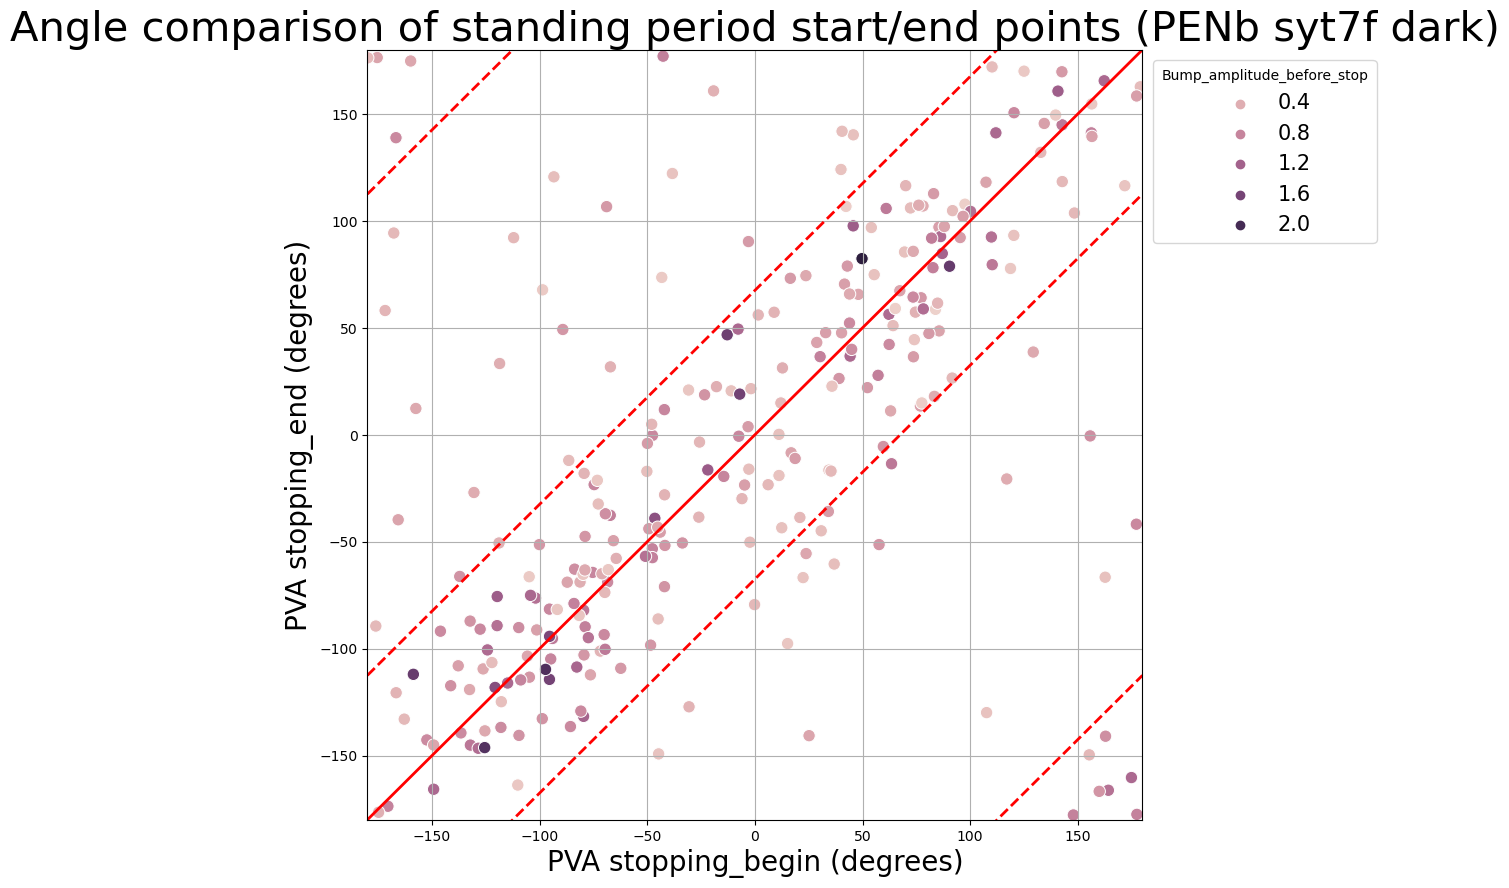

In [40]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_at_restart', hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_before_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='r', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color= 'r', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='r', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Angle comparison of standing period start/end points (PENb syt7f dark)', fontsize =30)
plt.ylabel('PVA stopping_end (degrees)',fontsize= 20)
plt.xlabel('PVA stopping_begin (degrees)',fontsize= 20)
plt.show()

In [41]:
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(persistence_data_pooled['PVA_before_stop'])

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(persistence_data_pooled['PVA_before_stop'],size = pair_num)
    random_stop_end_angle = np.random.choice(persistence_data_pooled['PVA_at_restart'],size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))    

In [42]:
actual_angle_diff = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])
actual_mean_absolute_angle_diff = np.mean(np.abs(actual_angle_diff))
actual_mean_absolute_angle_diff 

38.97110482902735

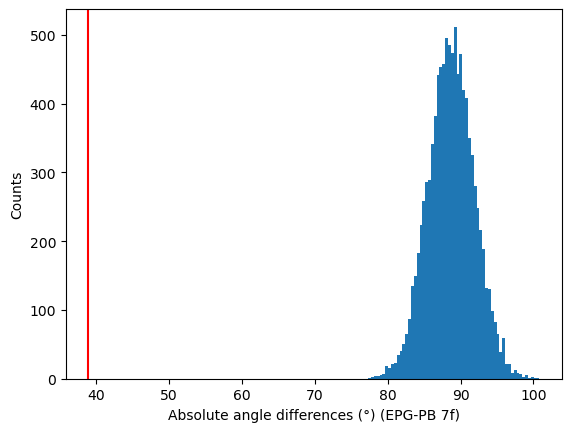

In [43]:
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff, color = 'r')
plt.xlabel('Absolute angle differences (°) (EPG-PB 7f)')
plt.ylabel('Counts')
plt.show()

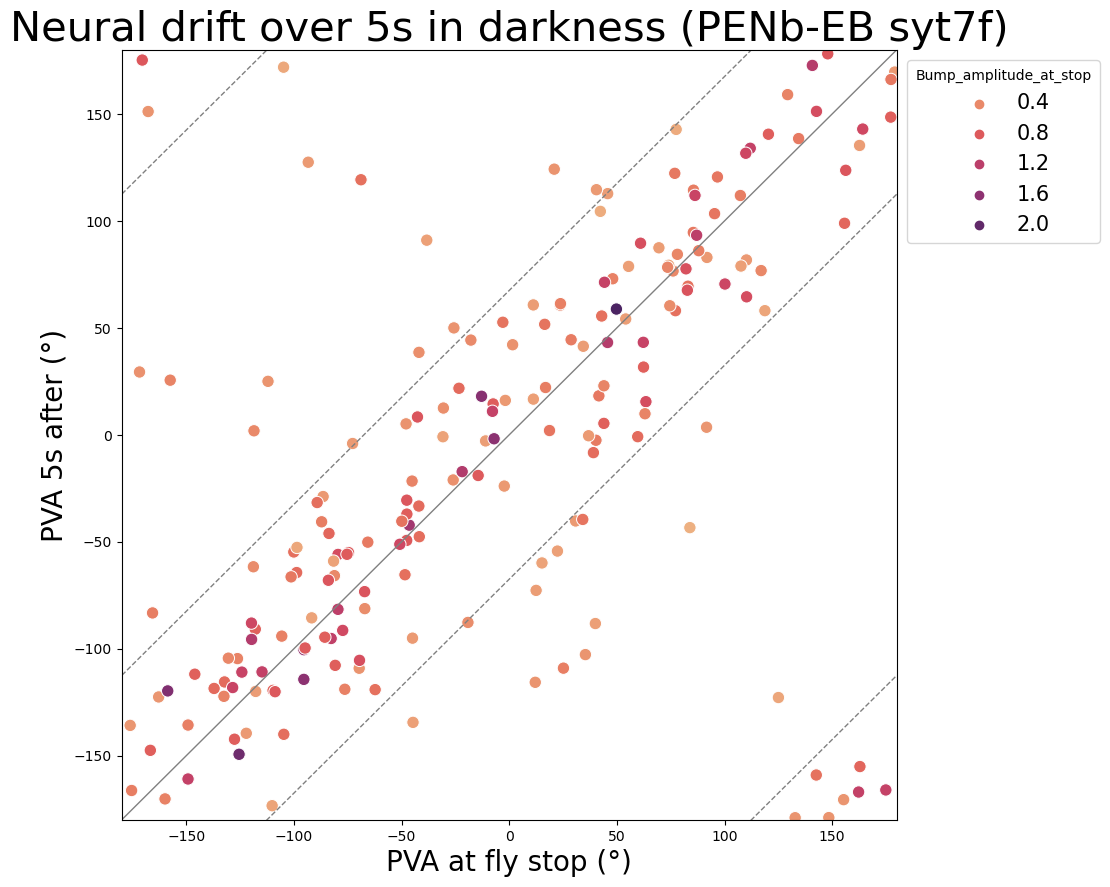

In [44]:
plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_5s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop',s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 5s in darkness (PENb-EB syt7f)', fontsize =30)
plt.ylabel('PVA 5s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()

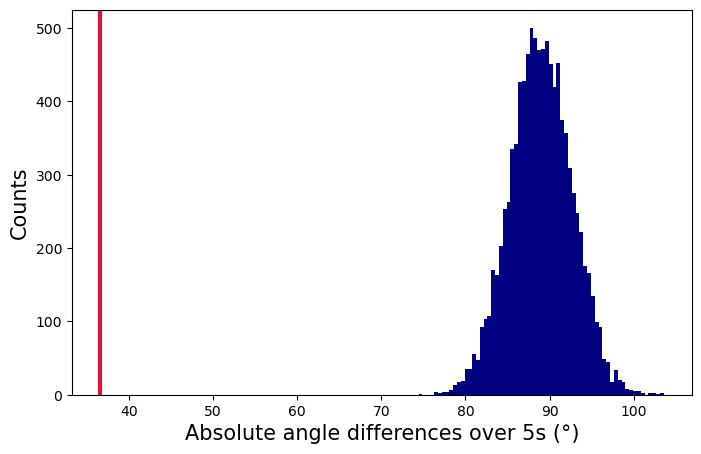

In [45]:
stop_period_start_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)))
stop_period_end_5s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_5s_after_stop'])==0)
for i in range(len(stop_period_start_5s )):
    stop_period_start_5s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_5s[i] =  persistence_data_pooled['PVA_5s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_5s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_5s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_5s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_5s =  calculate_angle_difference_between_two_time_point(stop_period_start_5s ,stop_period_end_5s)
actual_mean_absolute_angle_diff_5s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_5s))
actual_mean_absolute_angle_diff_5s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto', color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_5s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 5s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()   

In [46]:
actual_mean_absolute_angle_diff_5s

36.59827270649015

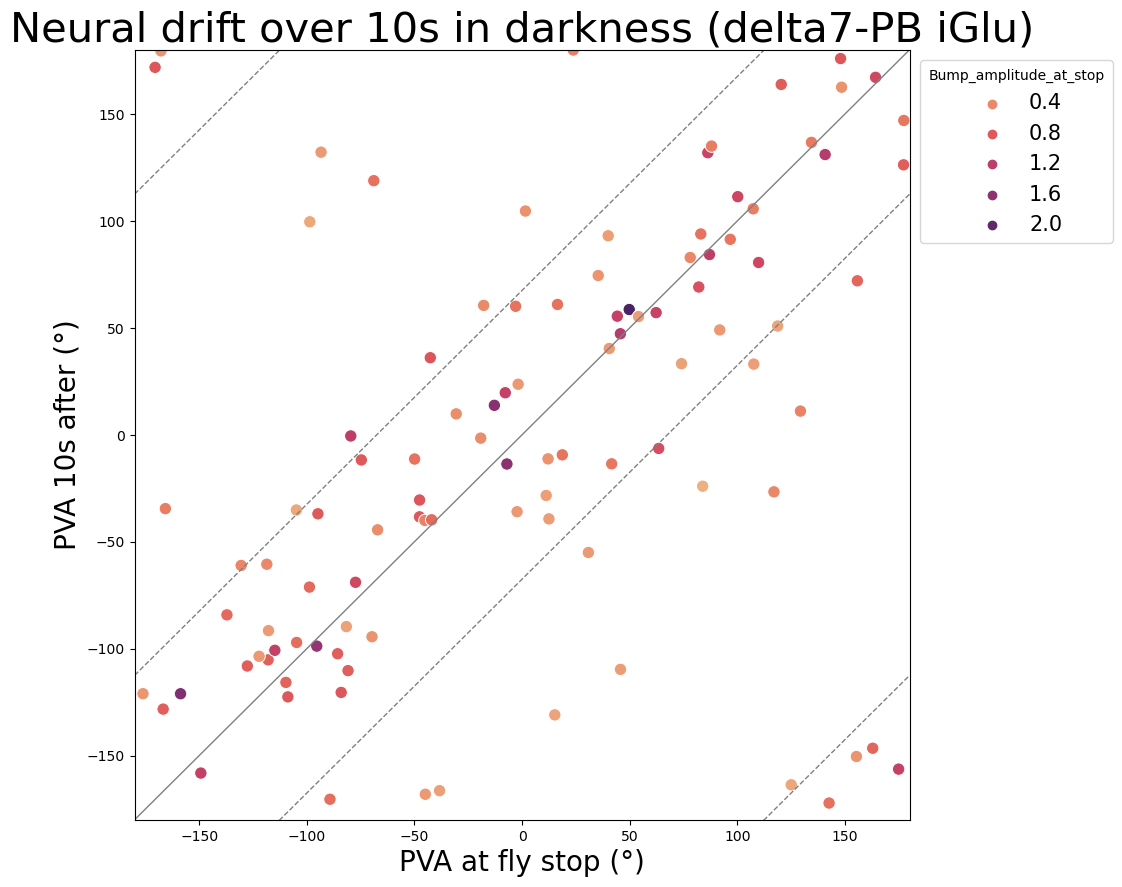

In [47]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = persistence_data_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', palette = 'flare',hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump_amplitude_at_stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =1)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =1)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =1)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Neural drift over 10s in darkness (delta7-PB iGlu)', fontsize =30)
plt.ylabel('PVA 10s after (°)',fontsize= 20)
plt.xlabel('PVA at fly stop (°)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
plt.show()
#a.savefig('E-PG_Bump_Angle_10s_after_cl', format ='svg')

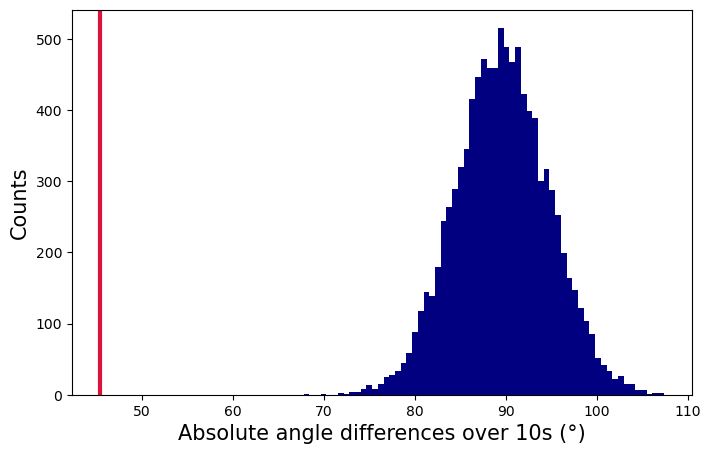

In [48]:
stop_period_start_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)))
stop_period_end_10s = np.zeros(len(np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(persistence_data_pooled['PVA_10s_after_stop'])==0)
for i in range(len(stop_period_start_10s )):
    stop_period_start_10s[i] = persistence_data_pooled['PVA_before_stop'][long_trial_index[i][0]]
    stop_period_end_10s[i] =  persistence_data_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(stop_period_start_10s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(stop_period_start_10s,size = pair_num)
    random_stop_end_angle = np.random.choice(stop_period_end_10s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_diff_10s =  calculate_angle_difference_between_two_time_point(stop_period_start_10s ,stop_period_end_10s)
actual_mean_absolute_angle_diff_10s = np.mean(np.abs(actual_mean_absolute_angle_diff_diff_10s))
actual_mean_absolute_angle_diff_10s     

plt.figure(figsize= (8,5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto',color = 'navy')
plt.axvline(x = actual_mean_absolute_angle_diff_10s, color = 'crimson',linewidth =3)
plt.xlabel('Absolute angle differences over 10s (°)',fontsize= 15)
plt.ylabel('Counts',fontsize= 15)
plt.show()

In [49]:
np.quantile(bootstrap_mean_angle_differences_10000,0.000000000001)

67.8012133839728

In [50]:
len(long_trial_index)

103

In [51]:
actual_mean_absolute_angle_diff_10s    

45.44480972144053

In [52]:
#from scipy.stats import ranksums
#ranksums(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [167]:
stats.mannwhitneyu(np.abs(actual_mean_absolute_angle_diff_dark_diff), np.abs(actual_mean_absolute_angle_diff_cl_diff), alternative = 'two-sided')

MannwhitneyuResult(statistic=3465.0, pvalue=0.0296191376401522)

In [173]:
np.savetxt('angle_difference_cl_10s.csv', np.abs(actual_mean_absolute_angle_diff_cl_diff))

In [56]:
persistence_data_pooled['angle difference start/middle'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_in_middle'])

In [57]:
persistence_data_pooled['angle difference start/end'] = calculate_angle_difference_between_two_time_point(persistence_data_pooled['PVA_before_stop'],persistence_data_pooled['PVA_at_restart'])

In [58]:
persistence_data_pooled

FlyTrial        Genotype TrialType  Period_duration  PVA_before_stop   
0    TQfly020-004  R60D05>GCaMP7f        cl          8.63612       152.779284  \
1    TQfly020-004  R60D05>GCaMP7f        cl          4.31806       -86.439229   
2    TQfly020-004  R60D05>GCaMP7f        cl         37.35624       -85.523872   
3    TQfly020-004  R60D05>GCaMP7f        cl          5.92478        -1.320021   
4    TQfly020-004  R60D05>GCaMP7f        cl          6.92898       104.161500   
..            ...             ...       ...              ...              ...   
144  TQfly006-004  R60D05>GCaMP7f        cl         20.02497       -42.736785   
145  TQfly006-004  R60D05>GCaMP7f        cl         23.74218       138.222288   
146  TQfly006-004  R60D05>GCaMP7f        cl         15.58830      -142.700005   
147  TQfly006-004  R60D05>GCaMP7f        cl         13.07019      -131.178308   
148  TQfly006-004  R60D05>GCaMP7f        cl         88.01394       149.353316   

     PVA_at_restart  PVA_100ms_before_restart  PVA_500ms_before_restart   
0        129.954677                156.596466                 16.232703  \
1        -68.797495                -74.962955                -69.155067   
2        -64.215069                -65.600353                -34.962486   
3         32.400089                 40.185377                 39.926749   
4        103.727001                105.218979                104.758681   
..              ...                       ...                       ...   
144      -77.586427                -48.538572                -72.358036   
145     -163.702983               -173.821122               -166.495025   
146     -149.362476               -157.569945                -99.942970   
147     -150.006876               -143.112831                177.899859   
148     -118.466666                 55.608811                 50.969139   

     PVA_in_middle  PVA_2s_before_restart  ...  bump_amplitude_at_restart   
0      -157.673166             113.858629  ...                   0.120168  \
1       -55.013859             -65.503918  ...                   0.494114   
2       -24.163843             -84.568892  ...                   0.124029   
3        43.955119              66.408276  ...                   0.502485   
4        96.081117              99.294985  ...                   0.958967   
..             ...                    ...  ...                        ...   
144    -132.141746            -100.250723  ...                   0.254206   
145    -165.264493             142.279049  ...                   0.238209   
146    -120.791635             162.518259  ...                   0.301008   
147    -127.937979            -165.489649  ...                   0.240625   
148      19.296692              47.018918  ...                   0.105966   

     bump_amplitude_100ms_before_restart  bump_amplitude_500ms_before_restart   
0                               0.118655                             0.180550  \
1                               0.514409                             0.639346   
2                               0.107755                             0.185554   
3                               0.438824                             0.672808   
4                               1.017992                             1.064665   
..                                   ...                                  ...   
144                             0.227604                             0.197644   
145                             0.248334                             0.241640   
146                             0.278209                             0.304520   
147                             0.240952                             0.214188   
148                             0.220290                             0.319481   

     bump_amplitude_in_middle  bump_amplitude_2s_before_restart   
0                    0.139993                          0.102664  \
1                    0.587214                          0.447535   
2                    0.201707       

In [59]:
persistence_data_pooled.to_csv('/home/tianhaoqiu/Documents/persistence_data_pooled_EPG_7f_PB_cl.csv',encoding = 'utf-8', index=False)